# Identity Expressions in Astrology Subreddits

## Abstract

## Research Question & Hypothesis

### Background, Prior Work

Zou, W., Tang, L., Zhou, M., & Zhang, X. (2024). Self-disclosure and received social support among women experiencing infertility on reddit: A natural language processing approach. *Computers in Human Behavior*, 154, 108159-.    
https://doi.org/10.1016/j.chb.2024.108159

Georgakopoulou, A., Iversen, S., & Stage, C. (2020). Quantified Storytelling : A Narrative Analysis of Metrics on Social Media (1st ed. 2020.). *Springer International Publishing*.    
https://doi.org/10.1007/978-3-030-48074-5

Zhou, Y., Squicciarini, A., & Rajtmajer, S. (2023). Lived experiences of online harm amongst marginalized and vulnerable individuals in support-seeking communities on Reddit.    
https://doi.org/10.48550/arxiv.2311.15427

Adelina, N., Chan, C. S., Takano, K., Yu, P. H. M., Wong, P. H. T., & Barry, T. J. (2023). The Stories We Tell Influence the Support We Receive: Examining the Reception of Support-Seeking Messages on Reddit. *Cyberpsychology, Behavior, and Social Networking, 26*(11), 823–834.   
https://doi.org/10.1089/cyber.2023.0144

Laughlin, C., & Li, M. (2023). “Are you me?”: understanding the political potential of feminist identity spaces on Reddit during the COVID-19 pandemic. *Communication, Culture & Critique, 16*(3), 174–181.     
https://doi.org/10.1093/ccc/tcad006

Reynolds, C., & Erikson, E. (2017). Agency, Identity, and the Emergence of Ritual Experience. Socius : *Sociological Research for a Dynamic World, 3.*     
https://doi.org/10.1177/2378023117710881

Mancini, T., & Imperato, C. (2024). Exploring intercultural sensitivity in bicultural and multicultural Reddit users: The role of both identity (or individual) and contextual (or social) factors. *Journal of Community & Applied Social Psychology, 34*(3).      
https://doi.org/10.1002/casp.2809

Rivera, E., Logan, E. S., & Price, A. (2024). The “Childfree” Movement: How Individuals Negotiate Identities on Reddit. *Journal of Public and Professional Sociology, 16*(1).     
https://doi.org/10.62915/2154-8935.1183

Miller, B. (2022). Exploring the Posting of Nude Photographs on Reddit in Relation to Self-Esteem, Perceived Attractiveness, Narcissism, and Sensation Seeking. *Archives of Sexual Behavior, 51*(6), 3083–3092.       
https://doi.org/10.1007/s10508-022-02301-y


### Hypothesis

## Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import praw
import re

import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style('darkgrid')

from tqdm import tqdm

import torch

from datetime import datetime

from zodiac_datetime import ZodiacFormatter
from zodiac_datetime import set_zodiac_locator, set_zodiac_formatter

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lmtua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Scraping Astrology Posts from Reddit
##### Skip to Preprocessing if Restarting Kernel

In [2]:
# API credentials
reddit = praw.Reddit(
    client_id='Yd1ZvPZA7iaSZ5XVv5-uRg',
    client_secret='EsncjC8WlPDfq4FHZaynum-K33S1bg',
    user_agent='AstrologyScraper/0.1 by u/No-Primary8213'
)

# Testing 
subreddit = reddit.subreddit('test')

In [3]:
subreddits = [
    'astrology',
    'Astrologydiscussion',
    'zodiacsigns',
    'Zodiac',
    'Horoscope',
    'AdvancedAstrology',
    'AskAstrologers',
    'astrologyreadings',
    'AstrologyBasics',
    'AstrologyChartShare',
    'beginnerastrology',
    'WorkingonitAstrology',
    'LetsFuckWithAstrology',
    'astrologymemes']

In [4]:
# Maximize number of posts by iterating through different time filters
time_filters = ['hour','day','week','month','all']
limit = 5000

# Scrape posts in astrology subreddits
posts = {}
for sr in subreddits:
    
    subreddit = reddit.subreddit(sr)
    
    for time_filter in tqdm(time_filters, desc=f'Scraping subreddit {sr}'):
        for submission in subreddit.top(time_filter=time_filter, limit=limit):
            posts[submission.id] = {
                'id': submission.id,
                'author': str(submission.author),
                'title': submission.title,
                'body': submission.selftext,
                'timestamp': datetime.utcfromtimestamp(submission.created_utc),
                'score': submission.score,
                'url': submission.url,
                'num_comments': submission.num_comments}

Scraping subreddit astrologymemes: 100%|██████████| 5/5 [00:40<00:00,  8.14s/it]


In [10]:
df_ = pd.DataFrame(posts).T.reset_index(drop=True)

In [7]:
# Sort scraped posts by number of comments
ids_ = df_.sort_values(by='num_comments', ascending=False)
ids = ids_.id[:500].values

# Scrape top ten comments by score
comments = {}
for id in tqdm(ids, desc=f'Scraping top comments'):
    
    # Flatten all nested comments in post
    submission = reddit.submission(id=id)
    submission.comments.replace_more(limit=0)
    
    # Rank comments by top score
    key = lambda c: c.score
    ranked = sorted(submission.comments, key=key, reverse=True)
    
    for comment in ranked[:10]:
        comments[id] = {
            'id': comment.id,
            'author': str(submission.author),
            'title': submission.title,
            'body': submission.selftext,
            'timestamp': datetime.utcfromtimestamp(comment.created_utc),
            'score': comment.score,
            'url': None,
            'num_comments': submission.num_comments}

Scraping top comments: 100%|██████████| 500/500 [17:00<00:00,  2.04s/it]


In [11]:
# Concatenate dataframes & preview shape
df__ = pd.DataFrame(comments).T.reset_index(drop=True)
df_  = pd.concat([df_, df__], axis=0)
df_

id                author  \
0    1kiys2v   GrandTrineAstrology   
1    1kmbtef  Disastrous_Average91   
2    1km35d4             minnegurl   
3    1klsrjb     lovemylittlelords   
4    1klzs67  Patient-Solution1060   
..       ...                   ...   
494  lni080l    sbaghetticarbonara   
495  lp8m75v   onionprincesswakaba   
496  mi5bcj5                og_dde   
497  lxzmz74        monochromedays   
498  m3xrq8s           IndigoRed33   

                                                 title  \
0    Horoscopes for the Scorpio Full Moon on May 12...   
1    I don’t get why people make such as difference...   
2                                   NN in Aries vs Leo   
3                       Saturn Return and Daddy Issues   
4    Has anyone studied Dynamics of Aspect Analysis...   
..                                                 ...   
494                                         Water suns   
495  Which sign is this and who are they talking ab...   
496                                     Gemini hate ?!   
497  Why are some astrologers telling cardinal sign...   
498                                        Romantic..💞   

                                                  body           timestamp  \
0    The horoscopes are written by looking at the i... 2025-05-10 01:30:46   
1    Are they really that different? I see it used ... 2025-05-14 10:32:04   
2    Can anyone explain the difference between thes... 2025-05-14 01:27:56   
3    I've read that Saturn can bring up issues arou... 2025-05-13 18:01:18   
4    Hi everyone,\n\nI’ve been deeply studying Bil ... 2025-05-13 22:45:16   
..                                                 ...                 ...   
494                                                    2024-09-17 00:52:56   
495                                                    2024-09-27 20:15:20   
496  As a Gemini, I've never met a Gemini with whom... 2025-03-16 20:29:44   
497  With pluto moving out of capricorn I've been s... 2024-11-19 20:54:51   
498                                                    2024-12-26 21:51:49   

    score                                                url num_comments  
0     609  https://www.reddit.com/r/astrology/comments/1k...           81  
1       8  https://www.reddit.com/r/astrology/comments/1k...           17  
2       3  https://www.reddit.com/r/astrology/comments/1k...            1  
3       4  https://www.reddit.com/r/astrology/comments/1k...            2  
4       2  https://www.reddit.com/r/astrology/comments/1k...            1  
..    ...                                                ...          ...  
494    38                                               None          221  
495    31                                               None          221  
496     6                                               None          220  
497     6                                               None          220  
498    27                                               None          220  

[15639 rows x 8 columns]

In [14]:
# Load dataset
df = pd.read_csv('astrology_subreddit.csv')

# Convert timestamp strings to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Concatenate with scraped posts then sort chronologically
df = df.rename(columns={'comms_num': 'num_comments'})
df = df[['id', 'title', 'body', 'timestamp', 'score', 'url', 'num_comments']]
df = pd.concat([df,df_], axis=0)
df = df.sort_values(by='timestamp')

# Preview shape
df.shape

(30177, 8)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30177 entries, 3793 to 9042
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            30177 non-null  object        
 1   title         30177 non-null  object        
 2   body          30128 non-null  object        
 3   timestamp     30177 non-null  datetime64[ns]
 4   score         30177 non-null  object        
 5   url           16980 non-null  object        
 6   num_comments  30177 non-null  object        
 7   author        15639 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 2.1+ MB


In [16]:
# Filter out posts without text then preview features & shape
mask = df.body.notna() & \
       df.body.str.strip().ne('') & \
       ~df.body.str.lower().isin(['[deleted]','[removed]']) 
df = df[mask].reset_index(drop=True)

df

id                                              title  \
0       4xyh2t                         Horoscope By Date of Birth   
1       592ne5         Gemini Sun, Scorpio Moon, Capricorn Rising   
2       6unr2r                     Hello Fellow Astrology Lovers!   
3       76iskx       Consider reading the FAQ/Wiki before posting   
4       7gijtx                 Analyzing Astrology (Natal) Charts   
...        ...                                                ...   
22287  1kmkbyi  Why do I keep making bad decisions lately, and...   
22288  1kmkbzh           Could you help me to understand, please?   
22289  1kmklwn                   Need help with interpreting this   
22290  1kmkt3o  Someone can help me reading my AstroCartograph...   
22291  1kmkvwt                      What is up with my love life?   

                                                    body           timestamp  \
0      If you want to know horoscope by date of birth... 2016-08-16 08:27:33   
1      Hello, I'm starting to get into astrology beca... 2016-10-24 04:06:37   
2      I want to thank you all for the awesome posts ... 2017-08-19 07:18:52   
3      This wiki is free to edit though [take a look ... 2017-10-15 12:55:11   
4      Hey guys! I've noticed this sub has gained a f... 2017-11-30 01:27:49   
...                                                  ...                 ...   
22287  I don't consider myself impulsive. Rather, I r... 2025-05-14 16:57:59   
22288  I am about to quit my job and get back to stud... 2025-05-14 16:58:01   
22289  Im new to this and having trouble interpreting... 2025-05-14 17:08:41   
22290  Thank you :)\n\n  \nI would like to know which... 2025-05-14 17:16:51   
22291  Is there anything in my chart that would indic... 2025-05-14 17:19:39   

      score                                                url num_comments  \
0         5  https://www.reddit.com/r/Horoscope/comments/4x...            0   
1        18  https://www.reddit.com/r/astrologyreadings/com...            9   
2         9  https://www.reddit.com/r/AstrologyChartShare/c...            1   
3       142  https://www.reddit.com/r/astrologyreadings/com...           33   
4       176  https://www.reddit.com/r/AstrologyChartShare/c...           41   
...     ...                                                ...          ...   
22287     1                https://i.redd.it/u0hysmzy2s0f1.png            1   
22288     1               https://i.redd.it/0h6oub563s0f1.jpeg            0   
22289     1                https://i.redd.it/v5o15h8z4s0f1.png            0   
22290     1                https://i.redd.it/0wn77gyb6s0f1.png            0   
22291     1               https://i.redd.it/e86rmt517s0f1.jpeg            0   

               author  
0      globaluser1241  
1             songlob  
2       AdmirableByrd  
3          Madbrad200  
4       AdmirableByrd  
...               ...  
22287  SporadicEmoter  
22288  torrevelasca33  
22289     cutiebear29  
22290    tannhauser00  
22291    DragTriangle  

[22292 rows x 8 columns]

In [17]:
df.to_csv('astrology_total.csv', index=False)

### Preprocessing
#### Text Standardization

In [3]:
# Load dataset
df = pd.read_csv('astrology_total.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# Extract hour, day, month, & year of each post as new dataset columns
df['hour_']  = df['timestamp'].apply(lambda dt: dt.time().hour)
df['day_']   = df['timestamp'].apply(lambda dt: dt.date().day)
df['month_'] = df['timestamp'].apply(lambda dt: dt.date().month)
df['year_']  = df['timestamp'].apply(lambda dt: dt.date().year)

In [5]:
df_a = df.copy()

# If entry is a submission, combine title & body as single text,
# & assign body to text otherwise
submissions_index = df_a[df_a.title != 'Comment'].index

df_a['text_'] = ''
for i in df_a.index:
    
    title = str(df_a.loc[i,'title'])
    body  = str(df_a.loc[i,'body'])
    
    if i in submissions_index:
        df_a.loc[i,'text_'] = title + '. ' + body
    else:
        df_a.loc[i,'text_'] = body

df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22292 entries, 0 to 22291
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            22292 non-null  object        
 1   title         22292 non-null  object        
 2   body          22292 non-null  object        
 3   timestamp     22292 non-null  datetime64[ns]
 4   score         22292 non-null  int64         
 5   url           9311 non-null   object        
 6   num_comments  22292 non-null  int64         
 7   author        7803 non-null   object        
 8   hour_         22292 non-null  int64         
 9   day_          22292 non-null  int64         
 10  month_        22292 non-null  int64         
 11  year_         22292 non-null  int64         
 12  text_         22292 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 2.2+ MB


In [6]:
# Helper function to standardize_text()
def _remove_stopwords(t):
    
    stopwords_ = stopwords.words('english')
    
    keep  = [word for word in str(t).split() if word not in stopwords_]
    text = ' '.join(keep)
    
    return text

In [7]:
# Function that standardizes the text of each post
def standardize_text(t):
    
    t = str(t)
    t = t.lower()
    t = re.sub(r'[^A-Za-z0-9]+', ' ', t)
    t = nltk.word_tokenize(t)
    t = " ".join(t)
    t = _remove_stopwords(t)
    
    return t

In [8]:
# Standardize text, tokenize text into sentence & word tokens & store
# number of respective tokens into separate columns
df_a['corpus'] = df_a['text_'].apply(lambda t: standardize_text(t))

df_a['sent_tokens'] = df_a['text_'].apply(lambda t: len(sent_tokenize(t)))
df_a['word_tokens'] = df_a['corpus'].apply(lambda c: len(c))

In [9]:
df_a.describe()[['sent_tokens', 'word_tokens']].T.iloc[:,1:]

mean          std  min   25%    50%    75%      max
sent_tokens    6.920734    14.266746  1.0   2.0    4.0    7.0    301.0
word_tokens  430.607034  1147.706329  0.0  71.0  170.0  365.0  30737.0

In [10]:
df_a

id                                              title  \
0       4xyh2t                         Horoscope By Date of Birth   
1       592ne5         Gemini Sun, Scorpio Moon, Capricorn Rising   
2       6unr2r                     Hello Fellow Astrology Lovers!   
3       76iskx       Consider reading the FAQ/Wiki before posting   
4       7gijtx                 Analyzing Astrology (Natal) Charts   
...        ...                                                ...   
22287  1kmkbyi  Why do I keep making bad decisions lately, and...   
22288  1kmkbzh           Could you help me to understand, please?   
22289  1kmklwn                   Need help with interpreting this   
22290  1kmkt3o  Someone can help me reading my AstroCartograph...   
22291  1kmkvwt                      What is up with my love life?   

                                                    body           timestamp  \
0      If you want to know horoscope by date of birth... 2016-08-16 08:27:33   
1      Hello, I'm starting to get into astrology beca... 2016-10-24 04:06:37   
2      I want to thank you all for the awesome posts ... 2017-08-19 07:18:52   
3      This wiki is free to edit though [take a look ... 2017-10-15 12:55:11   
4      Hey guys! I've noticed this sub has gained a f... 2017-11-30 01:27:49   
...                                                  ...                 ...   
22287  I don't consider myself impulsive. Rather, I r... 2025-05-14 16:57:59   
22288  I am about to quit my job and get back to stud... 2025-05-14 16:58:01   
22289  Im new to this and having trouble interpreting... 2025-05-14 17:08:41   
22290  Thank you :)\n\n  \nI would like to know which... 2025-05-14 17:16:51   
22291  Is there anything in my chart that would indic... 2025-05-14 17:19:39   

       score                                                url  num_comments  \
0          5  https://www.reddit.com/r/Horoscope/comments/4x...             0   
1         18  https://www.reddit.com/r/astrologyreadings/com...             9   
2          9  https://www.reddit.com/r/AstrologyChartShare/c...             1   
3        142  https://www.reddit.com/r/astrologyreadings/com...            33   
4        176  https://www.reddit.com/r/AstrologyChartShare/c...            41   
...      ...                                                ...           ...   
22287      1                https://i.redd.it/u0hysmzy2s0f1.png             1   
22288      1               https://i.redd.it/0h6oub563s0f1.jpeg             0   
22289      1                https://i.redd.it/v5o15h8z4s0f1.png             0   
22290      1                https://i.redd.it/0wn77gyb6s0f1.png             0   
22291      1               https://i.redd.it/e86rmt517s0f1.jpeg             0   

               author  hour_  day_  month_  year_  \
0      globaluser1241      8    16       8   2016   
1             songlob      4    24      10   2016   
2       AdmirableByrd      7    19       8   2017   
3          Madbrad200     12    15      10   2017   
4       AdmirableByrd      1    30      11   2017   
...               ...    ...   ...     ...    ...   
22287  SporadicEmoter     16    14       5   2025   
22288  torrevelasca33     16    14       5   2025   
22289     cutiebear29     17    14       5   2025   
22290    tannhauser00     17    14       5   2025   
22291    DragTriangle     17    14       5   2025   

                                                   text_  \
0      Horoscope By Date of Birth. If you want to kno...   
1      Gemini Sun, Scorpio Moon, Capricorn Rising. He...   
2      Hello Fellow Astrology Lovers!. I want to than...   
3      Consider reading the FAQ/Wiki before posting. ...   
4      Analyzing Astrology (Natal) Charts. Hey guys! ...   
...                                                  ...   
22287  Why do I keep making bad decisions lately, and...   
22288  Could you help me to understand, please?. I am...   
22289  Need help with interpreting this. Im new to th...   
22290  Someo

In [11]:
# Retrieve most substantial posts w.r.t. how the texts have been tokenized
k = int(df_a.shape[0]/2)

text_idx = set(df_a.sort_values(by='sent_tokens', ascending=False).iloc[:k,:].index)
word_idx = set(df_a.sort_values(by='word_tokens', ascending=False).iloc[:k,:].index)
text_idx.update(word_idx)

df_text = df_a[df_a.index.isin(text_idx)]
df_text = df_text.drop(columns=['title','body'], axis=1)
df_text = df_text.sort_values(by='timestamp')
df_text

id           timestamp  score  \
0       4xyh2t 2016-08-16 08:27:33      5   
1       592ne5 2016-10-24 04:06:37     18   
2       6unr2r 2017-08-19 07:18:52      9   
3       76iskx 2017-10-15 12:55:11    142   
4       7gijtx 2017-11-30 01:27:49    176   
...        ...                 ...    ...   
22284  1kmjp92 2025-05-14 16:33:23      2   
22286  1kmk0js 2025-05-14 16:45:31      1   
22287  1kmkbyi 2025-05-14 16:57:59      1   
22288  1kmkbzh 2025-05-14 16:58:01      1   
22291  1kmkvwt 2025-05-14 17:19:39      1   

                                                     url  num_comments  \
0      https://www.reddit.com/r/Horoscope/comments/4x...             0   
1      https://www.reddit.com/r/astrologyreadings/com...             9   
2      https://www.reddit.com/r/AstrologyChartShare/c...             1   
3      https://www.reddit.com/r/astrologyreadings/com...            33   
4      https://www.reddit.com/r/AstrologyChartShare/c...            41   
...                                                  ...           ...   
22284  https://www.reddit.com/r/astrologymemes/commen...             0   
22286               https://i.redd.it/pncg1mzx0s0f1.jpeg             1   
22287                https://i.redd.it/u0hysmzy2s0f1.png             1   
22288               https://i.redd.it/0h6oub563s0f1.jpeg             0   
22291               https://i.redd.it/e86rmt517s0f1.jpeg             0   

                 author  hour_  day_  month_  year_  \
0        globaluser1241      8    16       8   2016   
1               songlob      4    24      10   2016   
2         AdmirableByrd      7    19       8   2017   
3            Madbrad200     12    15      10   2017   
4         AdmirableByrd      1    30      11   2017   
...                 ...    ...   ...     ...    ...   
22284  itsareverseharem     16    14       5   2025   
22286    Sad-Tutor-7704     16    14       5   2025   
22287    SporadicEmoter     16    14       5   2025   
22288    torrevelasca33     16    14       5   2025   
22291      DragTriangle     17    14       5   2025   

                                                   text_  \
0      Horoscope By Date of Birth. If you want to kno...   
1      Gemini Sun, Scorpio Moon, Capricorn Rising. He...   
2      Hello Fellow Astrology Lovers!. I want to than...   
3      Consider reading the FAQ/Wiki before posting. ...   
4      Analyzing Astrology (Natal) Charts. Hey guys! ...   
...                                                  ...   
22284  Chiron in Aries. Has anyone healed theirs? Is ...   
22286  Mom gave me the wrong birth time & my rising s...   
22287  Why do I keep making bad decisions lately, and...   
22288  Could you help me to understand, please?. I am...   
22291  What is up with my love life?. Is there anythi...   

                                                  corpus  sent_tokens  \
0      horoscope date birth want know horoscope date ...            2   
1      gemini sun scorpio moon capricorn rising hello...           16   
2      hello fellow astrology lovers want thank aweso...           12   
3      consider reading faq wiki posting wiki free ed...           58   
4      analyzing astrology natal charts hey guys noti...           40   
...                                                  ...          ...   
22284  chiron aries anyone healed even possible swear...            7   
22286  mom gave wrong birth time rising sign differen...            5   
22287  keep making bad decisions lately stop consider...            6   
22288  could help understand please quit job get back...            6   
22291  love life anything chart would indicate relati...            4   

       word_tokens  
0              172  
1              753  
2              941  
3             4501  
4             4841  
...            ...  
22284          132  
22286          319  
22287          162  
22288          386  
22291           88  

[12712 rows x 14 columns]

## EDA

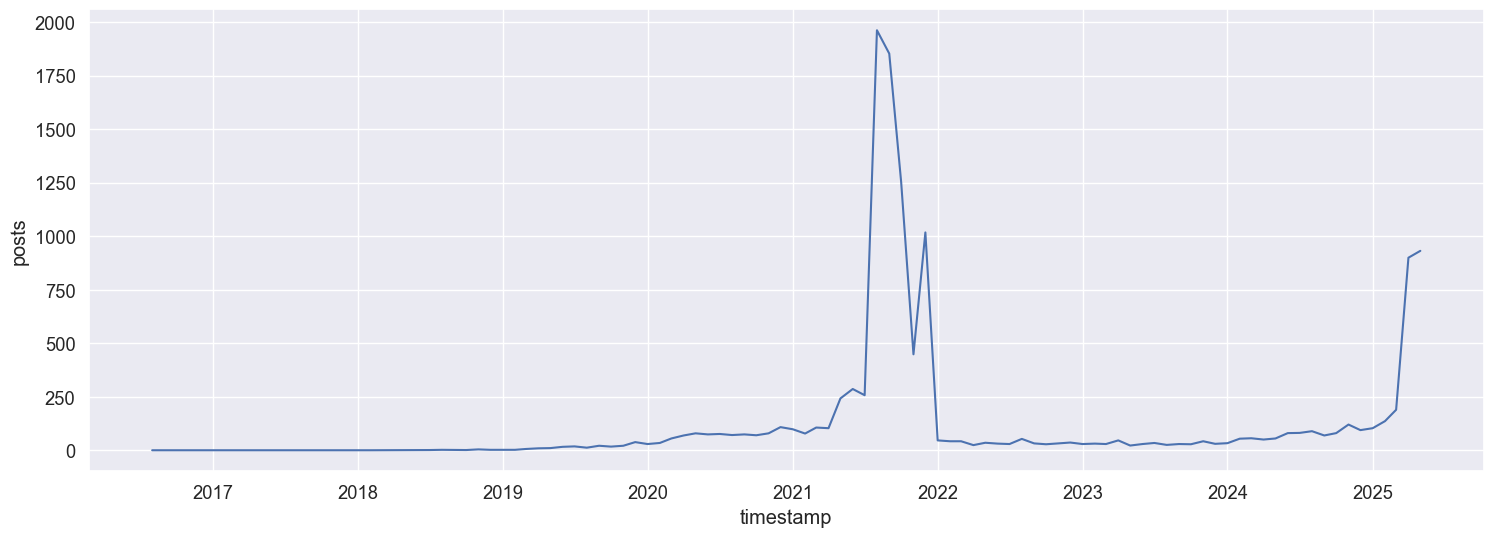

In [12]:
# Plotting post count over time 
multiindex = df_text.groupby(['year_']).month_.value_counts().index
x = [datetime(*(y,m,1)) for (y,m) in multiindex]

data = {
    'timestamp': x,
    'posts'    : df_text.groupby(['year_']).month_.value_counts().values
}

df_plt = pd.DataFrame(data=data)

plt.subplots(figsize=(18,6))
sns.lineplot(data=df_plt, x='timestamp', y='posts')
plt.show()

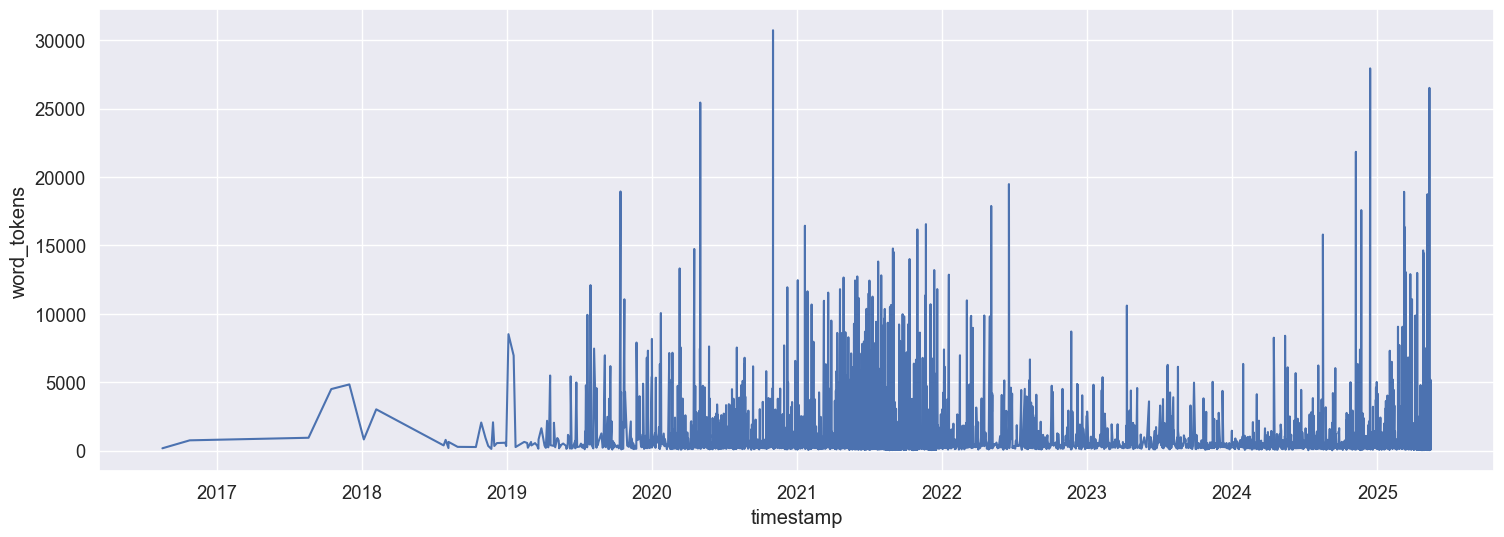

In [13]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_text, x='timestamp', y='word_tokens')
plt.show()

In [14]:
def plot_posts_over_time(df, date):
    
    months = ['Jan','Feb','Mar',
              'Apr','May','Jun',
              'Jul','Aug','Sep',
              'Oct', 'Nov', 'Dec']
    days   = [30, 28, 31, 30, 31, 30, 31, 31, 30, 31, 31, 31]
    
    m,d  = date
    fs   = 3 if d > 0 else 2
    figsize = (18,9) if d > 0 else (18,6)
    m_label = months[m-1].upper()
    
    f, axs = plt.subplots(fs, 1, figsize=figsize, layout='constrained')
    
    data_mon = df.month_.value_counts(sort=False)
    data_mon_ = {
        'month': df.month_.unique(),
        'posts': data_mon.tolist()
    }
    df_mon = pd.DataFrame(data=data_mon_)
    
    plt.subplot(fs,1,1)
    sns.lineplot(data=df_mon, x='month', y='posts', ax=axs[0])
    axs[0].xaxis.tick_top()
    axs[0].xaxis.set_label_position('top')
    plt.text(
        6.5, 
        (df_mon.posts.max()/2)-0.5, 
        '2021', 
        horizontalalignment='center',
        verticalalignment='center', 
        fontsize=125,
        alpha=0.2
    )
    plt.xticks(data_mon.index.tolist(), months)
    plt.xlabel('')
    plt.ylabel('')
    
    mask = df.month_ == m
    num_days = days[m]-1
    reindex_day = list(range(1,num_days))
    
    data_day = df[mask]['day_'].value_counts(sort=False)
    df_day = pd.DataFrame(data=data_day).reindex(reindex_day).fillna(0)
    df_day = df_day.reset_index()
    df_day.columns = ['day', 'posts']
    
    xticks_day = [str(d) for d in reindex_day]
    
    plt.subplot(fs,1,2)
    sns.lineplot(data=df_day, x='day', y='posts', ax=axs[1])
    plt.text(
        (num_days/2), 
        (df_day.posts.max()/2)-0.5, 
        m_label, 
        horizontalalignment='center',
        verticalalignment='center', 
        fontsize=125,
        alpha=0.2
    )
    plt.xticks(reindex_day, xticks_day)
    plt.xlabel('')
    plt.ylabel('')
    
    if d > 0:
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top')
        
        mask = (df.month_ == m) & (df.day_ == d)
        reindex_hour = list(range(24))
    
        data_hr = df[mask]['hour_'].value_counts(sort=False)
        df_hr = pd.DataFrame(data=data_hr).reindex(reindex_hour).fillna(0)
        df_hr = df_hr.reset_index()
        df_hr.columns = ['hour', 'posts']
    
        xticks_hour = [str(h) for h in reindex_hour]
        plt.subplot(fs,1,3)
        sns.lineplot(data=df_hr, x='hour', y='posts', ax=axs[2])
        axs[2].xaxis.tick_top()
        axs[2].xaxis.set_label_position('top')
        plt.xticks(reindex_hour, xticks_hour)
        plt.text(
            (23/2), 
            (df_hr.posts.max()/2)-0.5, 
            str(d).upper(), 
            horizontalalignment='center',
            verticalalignment='center', 
            fontsize=125,
            alpha=0.2
        )
        plt.xlabel('')
        plt.ylabel('')

    f.supylabel('POSTS')
    
    plt.show()

In [15]:
df_2021 = df_text[df_text.year_==2021]

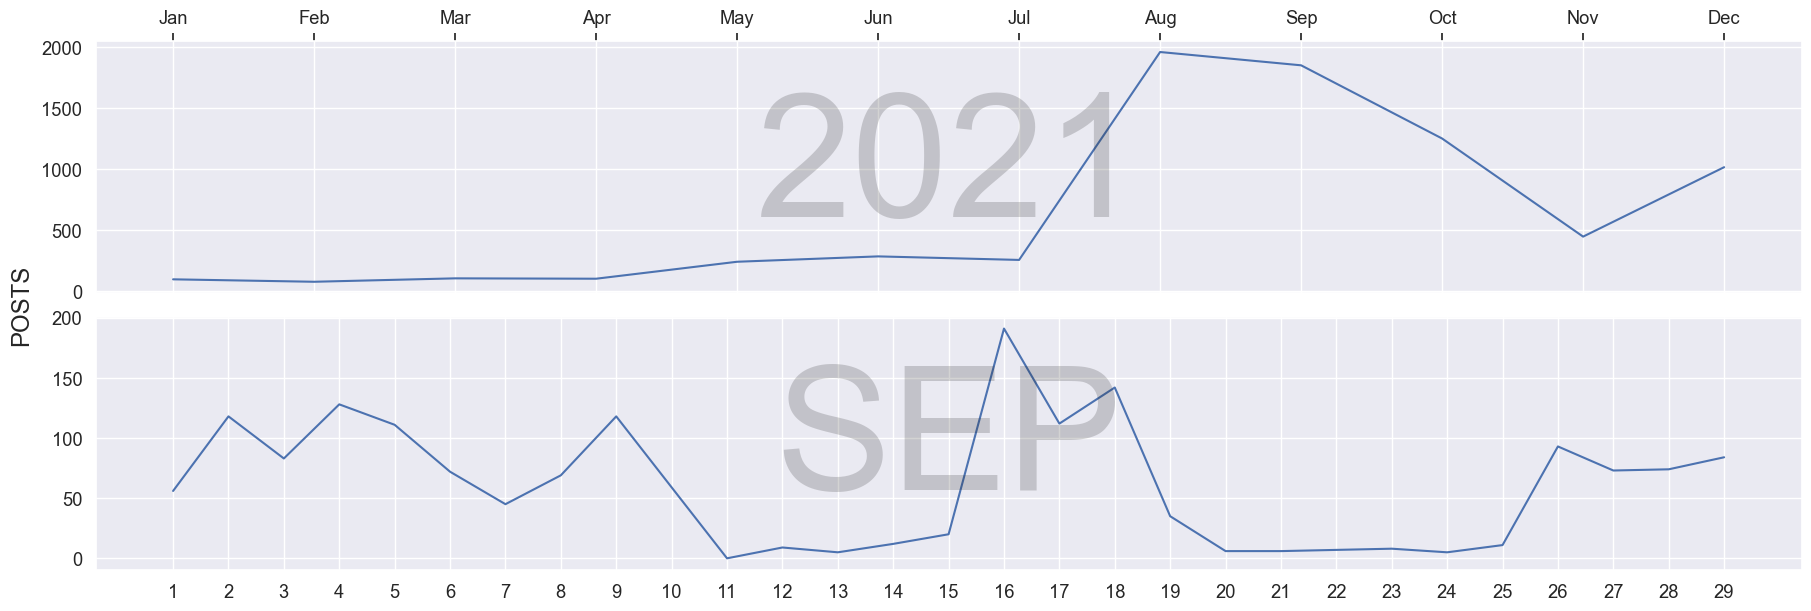

In [16]:
plot_posts_over_time(df_2021, (9,0))

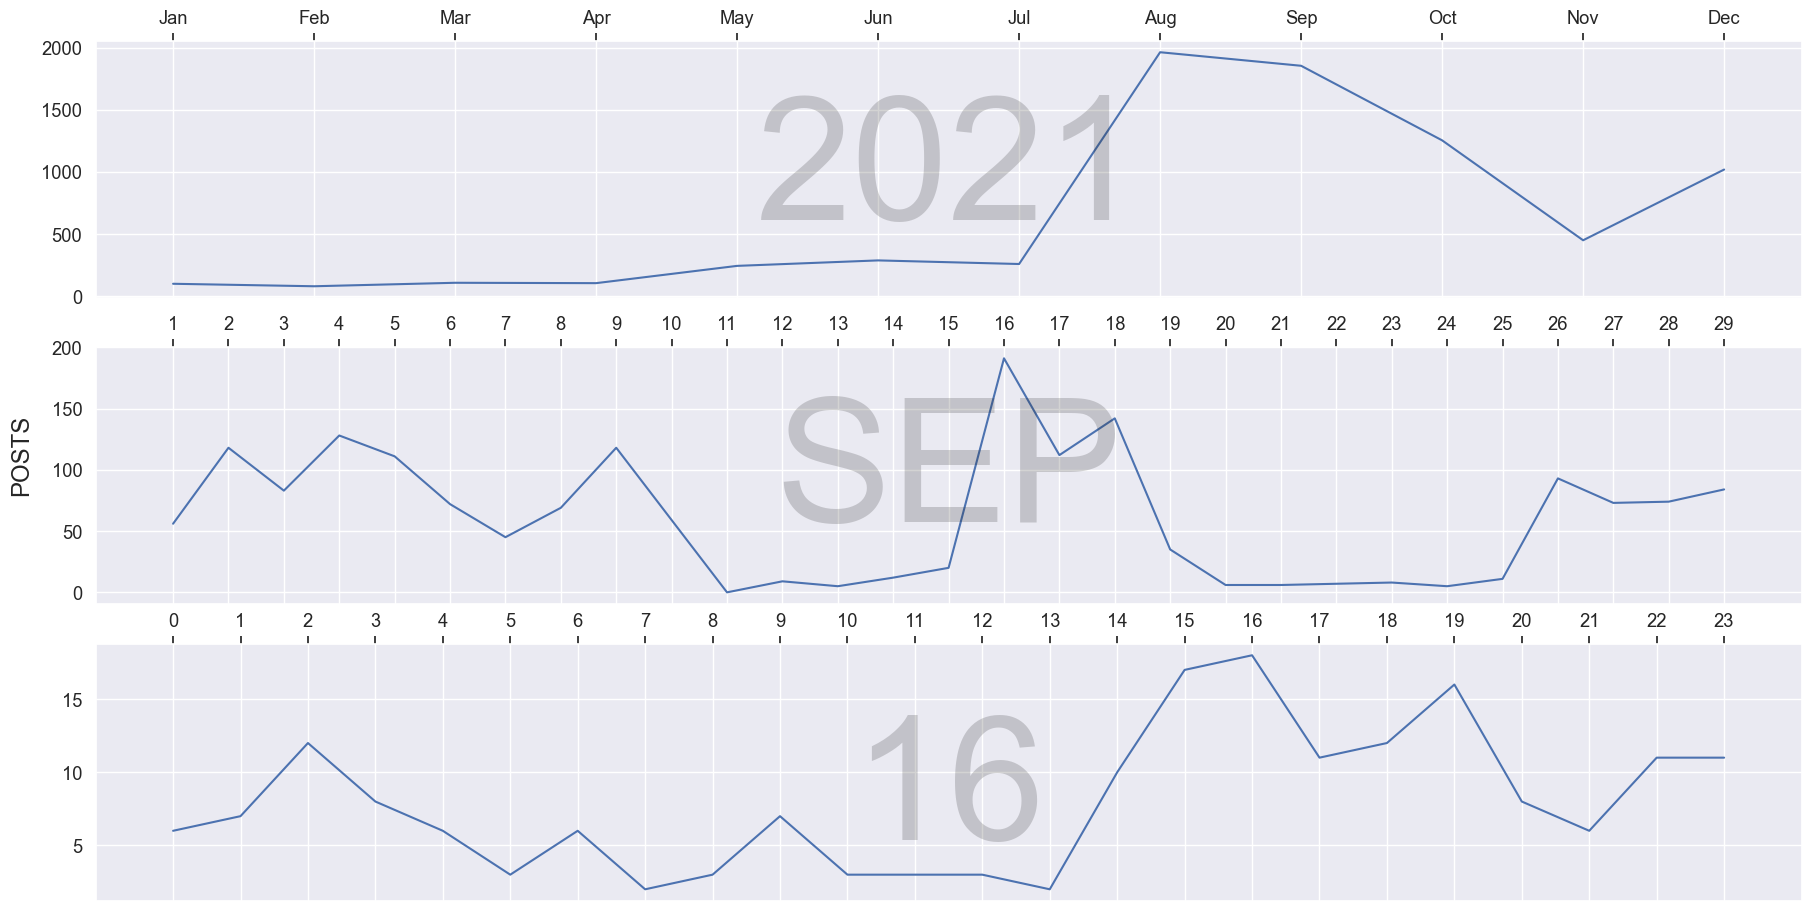

In [17]:
plot_posts_over_time(df_2021, (9,16))

In [18]:
def generate_wordcloud(documents):

    corpus = ' '.join(documents)

    cloud = WordCloud(
        max_words=500, 
        width=800, 
        height=400, 
        background_color='white'
    ).generate(corpus)
    
    plt.figure(figsize=(30,20))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()

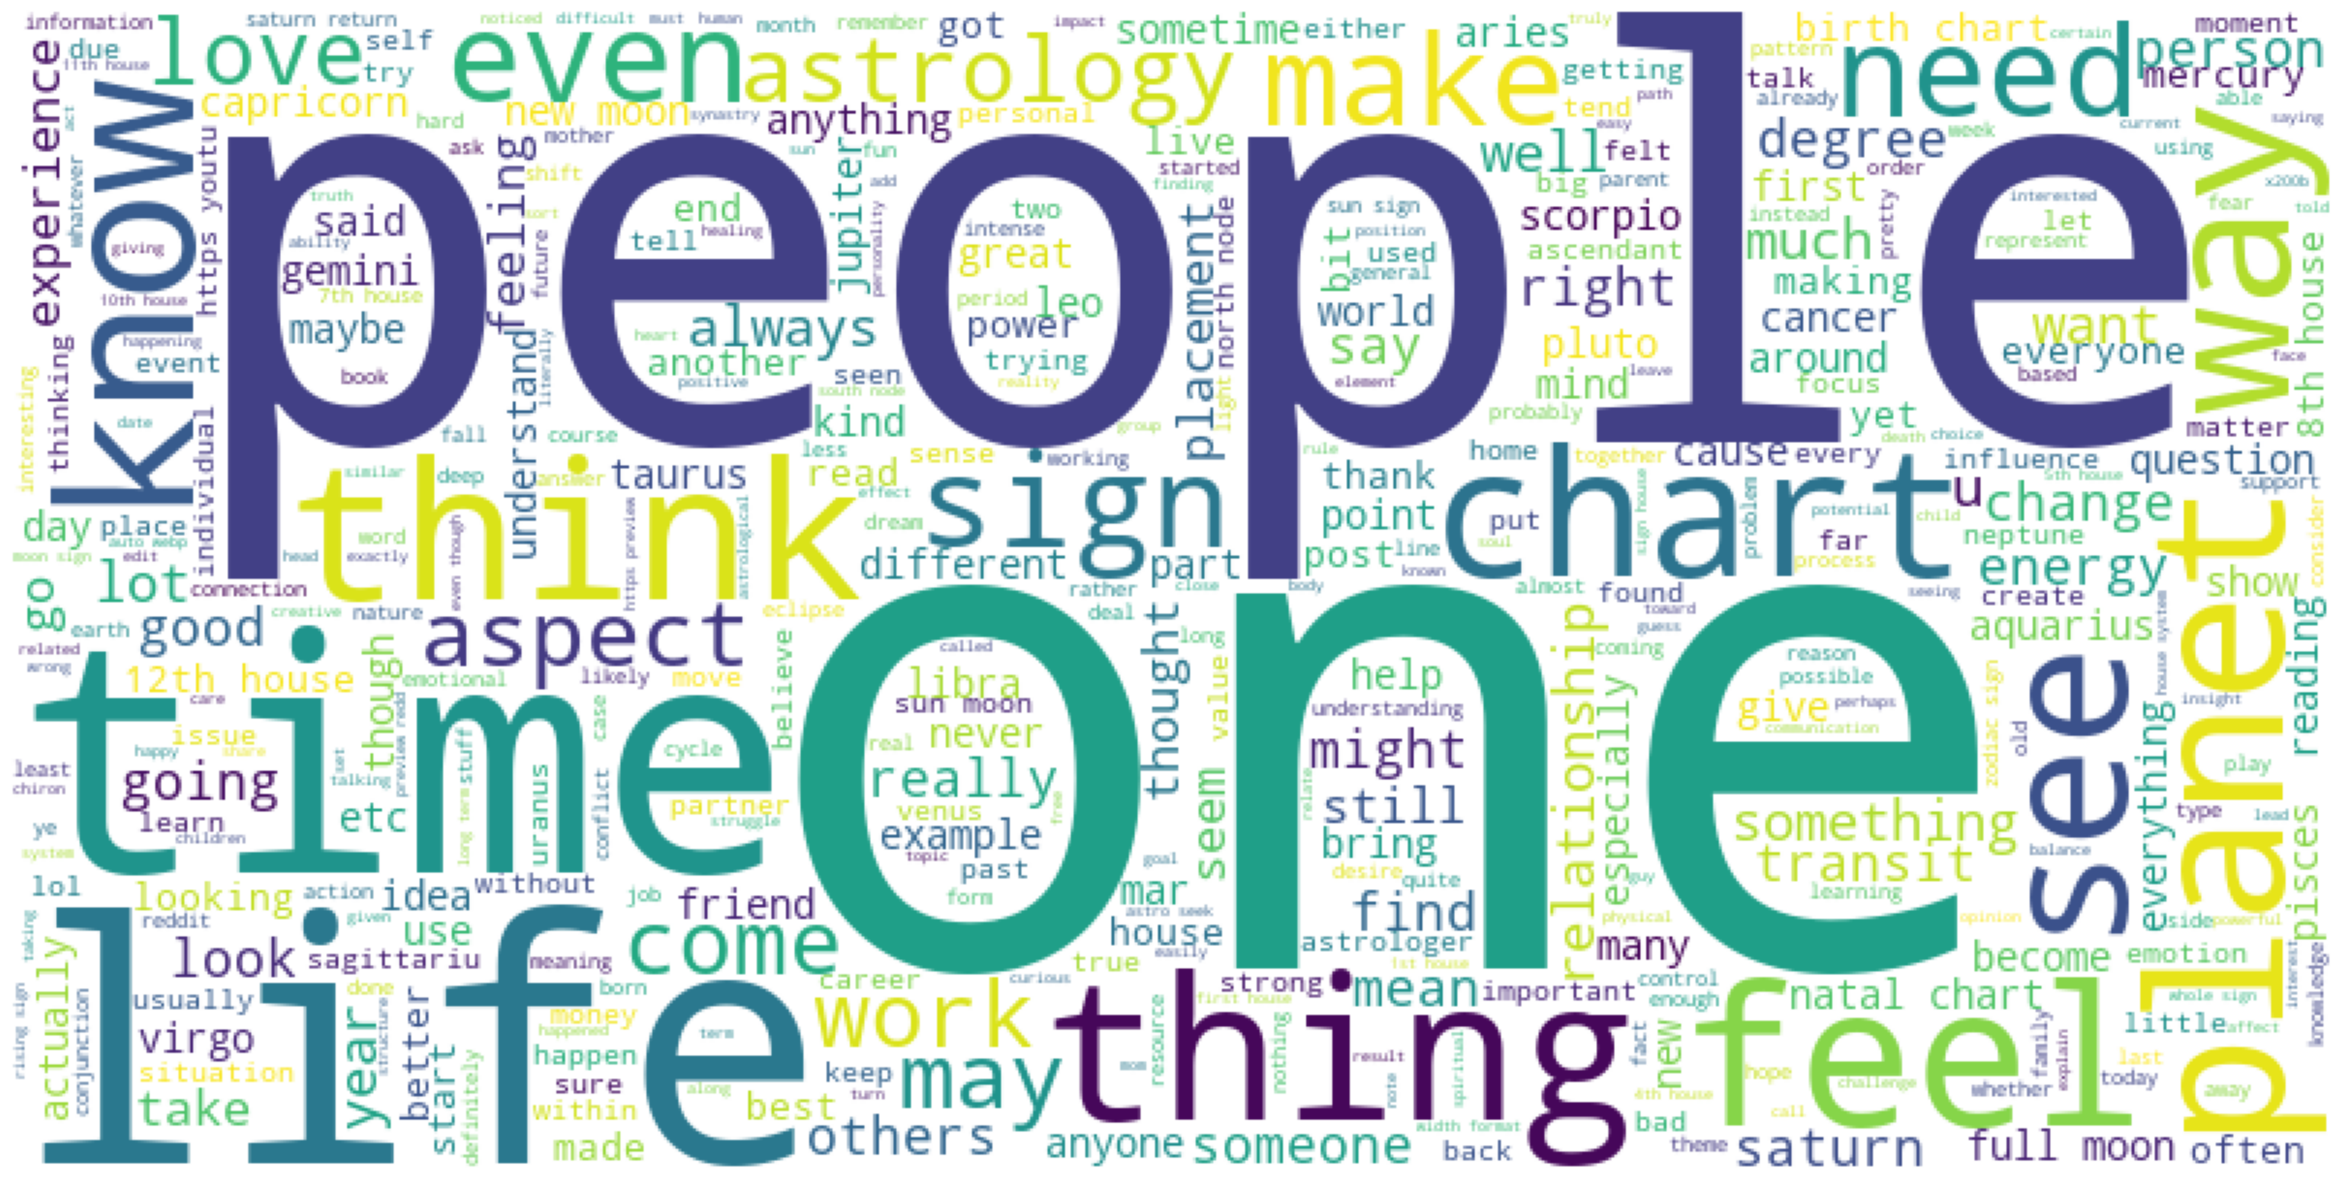

In [19]:
generate_wordcloud(df_text.corpus.tolist())

In [20]:
def tfidf(df):
    
    vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        analyzer='word',
        max_features=None,
        min_df = 0.06,
        max_df = 0.75,
        tokenizer=word_tokenize,
        stop_words=stopwords.words('english')
    )
    
    tfidf_matrix = vectorizer.fit_transform(df['corpus'].tolist()).toarray()
    
    df_tfidf = pd.DataFrame(tfidf_matrix)
    df_tfidf.columns = vectorizer.get_feature_names_out()
    df_tfidf.index = df.index
    
    # Remove numerical features
    w = next(t for t in df_tfidf.columns.tolist() if t[0]=='a')
    i = df_tfidf.columns.tolist().index(w)
    df_tfidf = df_tfidf.iloc[:,i:]
    
    return df_tfidf, vectorizer.get_feature_names_out().tolist()

In [21]:
tfidf_, vocab = tfidf(df_text)
df_tfidf = pd.concat([df_text, tfidf_], axis=1)

In [22]:
print(vocab)

['1', '2', '3', 'actually', 'also', 'always', 'another', 'anyone', 'anything', 'aquarius', 'aries', 'around', 'aspect', 'aspects', 'astrology', 'back', 'bad', 'best', 'better', 'big', 'birth', 'bit', 'cancer', 'capricorn', 'change', 'chart', 'charts', 'com', 'come', 'comes', 'conjunct', 'could', 'day', 'different', 'else', 'end', 'energy', 'especially', 'etc', 'even', 'every', 'everyone', 'everything', 'example', 'experience', 'feel', 'feeling', 'find', 'first', 'friends', 'full', 'gemini', 'get', 'getting', 'give', 'go', 'going', 'good', 'got', 'great', 'hard', 'help', 'house', 'houses', 'https', 'important', 'jupiter', 'kind', 'know', 'last', 'learn', 'leo', 'let', 'libra', 'life', 'like', 'little', 'long', 'look', 'looking', 'lot', 'love', 'made', 'make', 'makes', 'making', 'many', 'mars', 'may', 'maybe', 'mean', 'means', 'mercury', 'might', 'mind', 'moon', 'much', 'natal', 'need', 'neptune', 'never', 'new', 'next', 'often', 'one', 'others', 'part', 'past', 'people', 'person', 'pers

In [23]:
df_tfidf

id           timestamp  score  \
0       4xyh2t 2016-08-16 08:27:33      5   
1       592ne5 2016-10-24 04:06:37     18   
2       6unr2r 2017-08-19 07:18:52      9   
3       76iskx 2017-10-15 12:55:11    142   
4       7gijtx 2017-11-30 01:27:49    176   
...        ...                 ...    ...   
22284  1kmjp92 2025-05-14 16:33:23      2   
22286  1kmk0js 2025-05-14 16:45:31      1   
22287  1kmkbyi 2025-05-14 16:57:59      1   
22288  1kmkbzh 2025-05-14 16:58:01      1   
22291  1kmkvwt 2025-05-14 17:19:39      1   

                                                     url  num_comments  \
0      https://www.reddit.com/r/Horoscope/comments/4x...             0   
1      https://www.reddit.com/r/astrologyreadings/com...             9   
2      https://www.reddit.com/r/AstrologyChartShare/c...             1   
3      https://www.reddit.com/r/astrologyreadings/com...            33   
4      https://www.reddit.com/r/AstrologyChartShare/c...            41   
...                                                  ...           ...   
22284  https://www.reddit.com/r/astrologymemes/commen...             0   
22286               https://i.redd.it/pncg1mzx0s0f1.jpeg             1   
22287                https://i.redd.it/u0hysmzy2s0f1.png             1   
22288               https://i.redd.it/0h6oub563s0f1.jpeg             0   
22291               https://i.redd.it/e86rmt517s0f1.jpeg             0   

                 author  hour_  day_  month_  year_  ...      want       way  \
0        globaluser1241      8    16       8   2016  ...  0.260568  0.000000   
1               songlob      4    24      10   2016  ...  0.000000  0.000000   
2         AdmirableByrd      7    19       8   2017  ...  0.221858  0.000000   
3            Madbrad200     12    15      10   2017  ...  0.090737  0.107432   
4         AdmirableByrd      1    30      11   2017  ...  0.000000  0.000000   
...                 ...    ...   ...     ...    ...  ...       ...       ...   
22284  itsareverseharem     16    14       5   2025  ...  0.000000  0.000000   
22286    Sad-Tutor-7704     16    14       5   2025  ...  0.000000  0.000000   
22287    SporadicEmoter     16    14       5   2025  ...  0.000000  0.000000   
22288    torrevelasca33     16    14       5   2025  ...  0.167497  0.000000   
22291      DragTriangle     17    14       5   2025  ...  0.000000  0.000000   

           well  whole  without      work  world     would  year     years  
0      0.000000    0.0      0.0  0.000000    0.0  0.000000   0.0  0.000000  
1      0.000000    0.0      0.0  0.000000    0.0  0.103123   0.0  0.000000  
2      0.134769    0.0      0.0  0.139855    0.0  0.110506   0.0  0.000000  
3      0.055119    0.0      0.0  0.000000    0.0  0.000000   0.0  0.000000  
4      0.000000    0.0      0.0  0.000000    0.0  0.083626   0.0  0.000000  
...         ...    ...      ...       ...    ...       ...   ...       ...  
22284  0.000000    0.0      0.0  0.000000    0.0  0.000000   0.0  0.000000  
22286  0.000000    0.0      0.0  0.000000    0.0  0.000000   0.0  0.164265  
22287  0.000000    0.0      0.0  0.000000    0.0  0.000000   0.0  0.000000  
22288  0.000000    0.0      0.0  0.000000    0.0  0.000000   0.0  0.318262  
22291  0.000000    0.0      0.0  0.000000    0.0  0.265425   0.0  0.000000  

[12712 rows x 191 columns]

In [24]:
def unique(df):
    
    df = df.iloc[:,df.columns.get_loc('word_tokens')+1:]
    
    ind  = df.index
    keys = ind.to_list()
    
    uniq = {}
    for i in ind:
        m = df.loc[i].max()
        mask = df.loc[i] == m
        u_w = df.columns[mask].tolist()
        uniq[i] = u_w
    
    d = dict(zip(keys,uniq.values()))
    ser = pd.Series(data=d, index=ind)
    
    df_uniq_ = pd.DataFrame(data=ser, index=ind, columns=['unique'])
    df_uniq_['unique'] = df_uniq_['unique'].apply(lambda I: I[0])
    
    occurrence = df_uniq_.unique.value_counts()
    df_uniq = pd.DataFrame(data=occurrence.values, columns=['occurrence'], index=occurrence.index)
    
    return df_uniq, uniq

In [25]:
df_u, u = unique(df_tfidf)

In [26]:
df_u.describe().T

count       mean        std   min   25%   50%    75%    max
occurrence  177.0  71.819209  49.041159  15.0  36.0  57.0  103.0  349.0

In [27]:
print(u)

{0: ['birth'], 1: ['great'], 2: ['past'], 3: ['com'], 4: ['com'], 5: ['aquarius'], 6: ['may'], 8: ['us'], 9: ['sign'], 11: ['astrology'], 12: ['astrology'], 14: ['question'], 15: ['https'], 17: ['anything'], 18: ['whole'], 19: ['little', 'please'], 20: ['capricorn'], 21: ['new'], 22: ['personal'], 23: ['next'], 24: ['please'], 25: ['aquarius'], 26: ['may'], 27: ['leo'], 28: ['love'], 29: ['signs'], 30: ['reading'], 31: ['love'], 32: ['learn'], 33: ['others'], 34: ['said'], 35: ['always'], 36: ['year'], 37: ['got'], 39: ['https'], 40: ['bad'], 41: ['past'], 42: ['feeling'], 43: ['things'], 45: ['else'], 46: ['would'], 47: ['aries'], 48: ['taurus'], 49: ['taurus'], 50: ['may'], 51: ['birth'], 54: ['natal'], 55: ['person'], 56: ['think'], 57: ['things'], 58: ['people'], 60: ['getting'], 62: ['anything'], 64: ['new'], 65: ['birth'], 66: ['sign'], 67: ['important'], 68: ['aries'], 69: ['new'], 71: ['planets'], 72: ['never'], 74: ['people'], 75: ['best'], 76: ['self'], 77: ['chart'], 78: ['k

In [28]:
df_u[:50].T

astrology  house  pluto  saturn  com  neptune  venus  year  mars  \
occurrence        349    262    249     236  187      153    149   144   142   

            virgo  ...  charts  transit  rising  placements  sign  planets  \
occurrence    142  ...     104      104     104         103   103      102   

            people  learn  capricorn  reading  
occurrence      99     99         99       98  

[1 rows x 50 columns]

In [29]:
def get_posts(df, key, num_posts, sort=False):
    col = ['timestamp', 'text_', 'sent_tokens', 'word_tokens', key]
    
    df_ = df.sort_values(by=key, ascending=False).head(num_posts)
    df_ = df_[col]
    
    if sort:
        df_ = df_[col].sort_values(by='timestamp')
    
    return df_

In [30]:
def plot_key_over_time(df, key, scale='Month'):
    f,ax = plt.subplots(figsize=(18,6))
    sns.lineplot(data=df, x='timestamp', y=key, ax=ax)

    if scale == 'Month':
        x_l = ''
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    else:
        set_zodiac_locator(ax, planet=scale)
        set_zodiac_formatter(ax, scale)
        x_l = scale + ' Ingresses (Phases, if Moon)'
    
    plt.xlabel(x_l)
    plt.ylabel(key, fontsize=28)
    plt.tight_layout()
    plt.show()

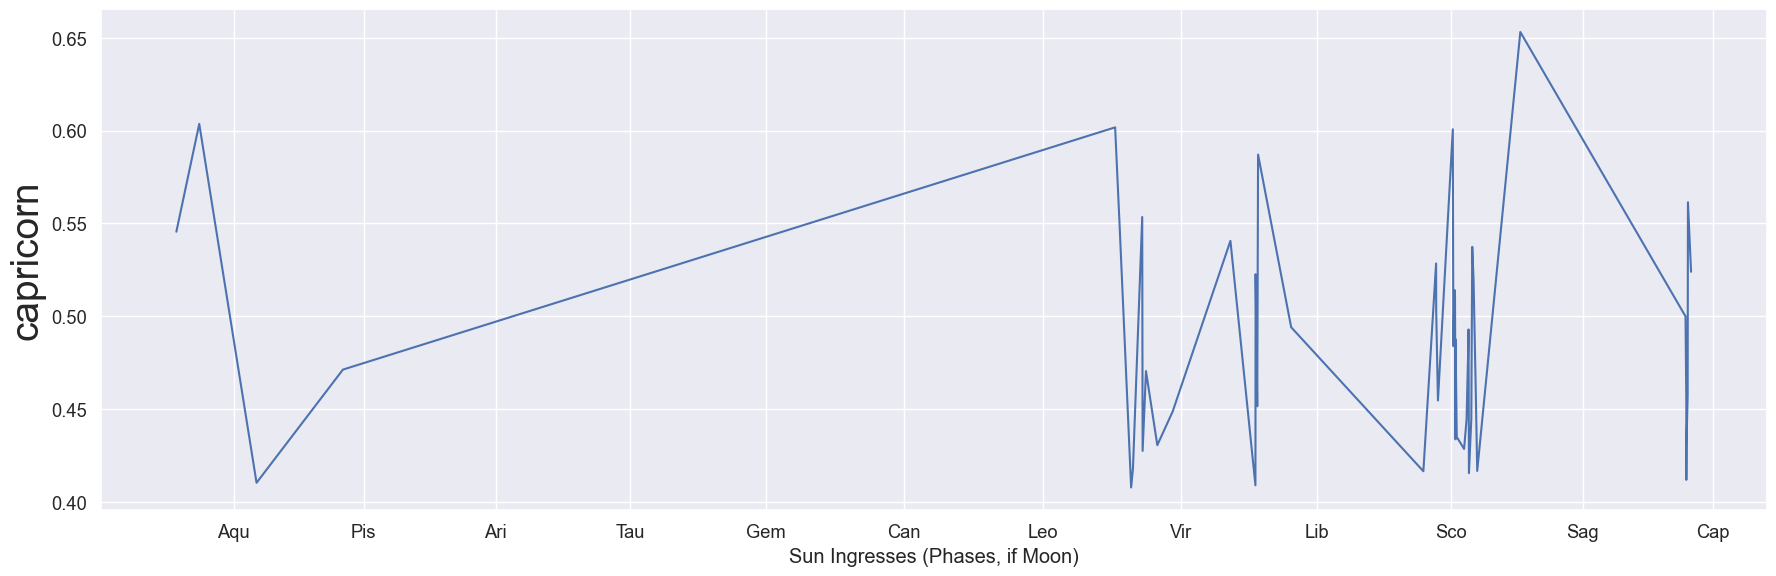

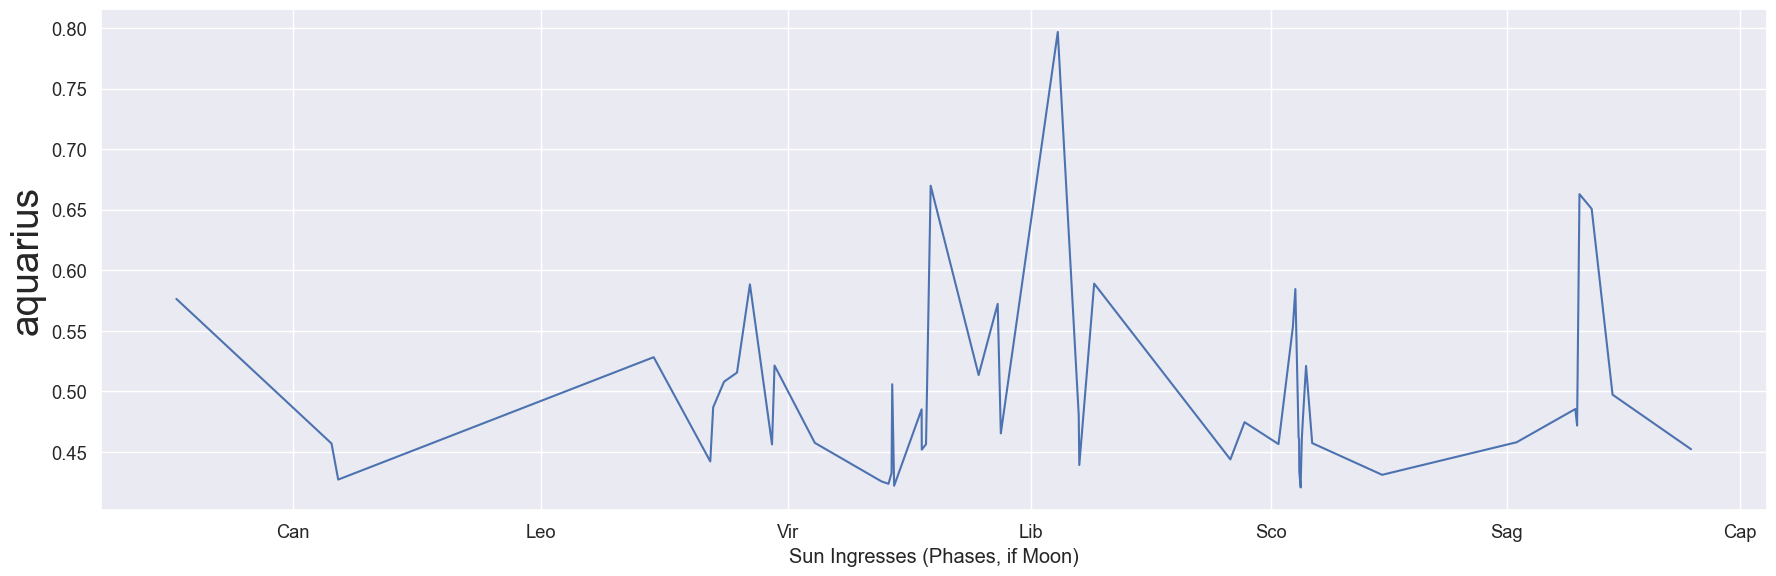

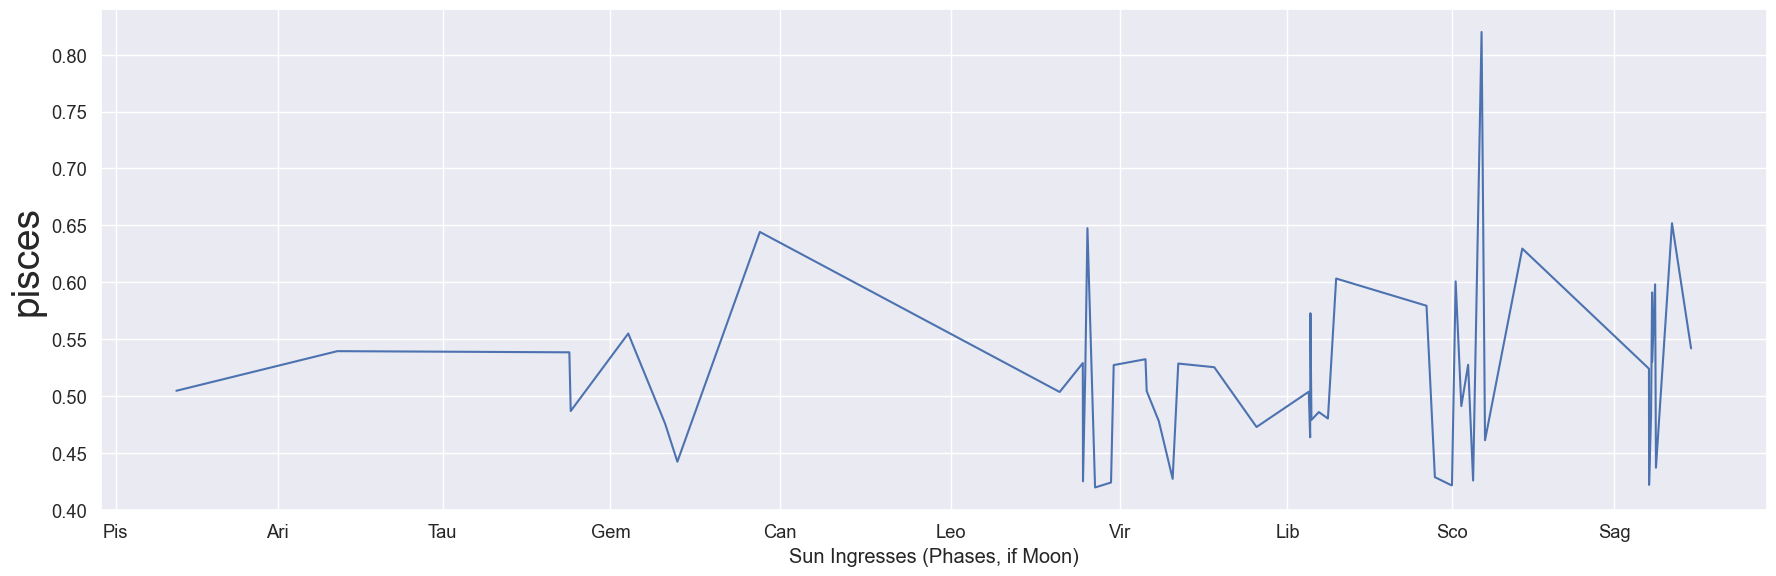

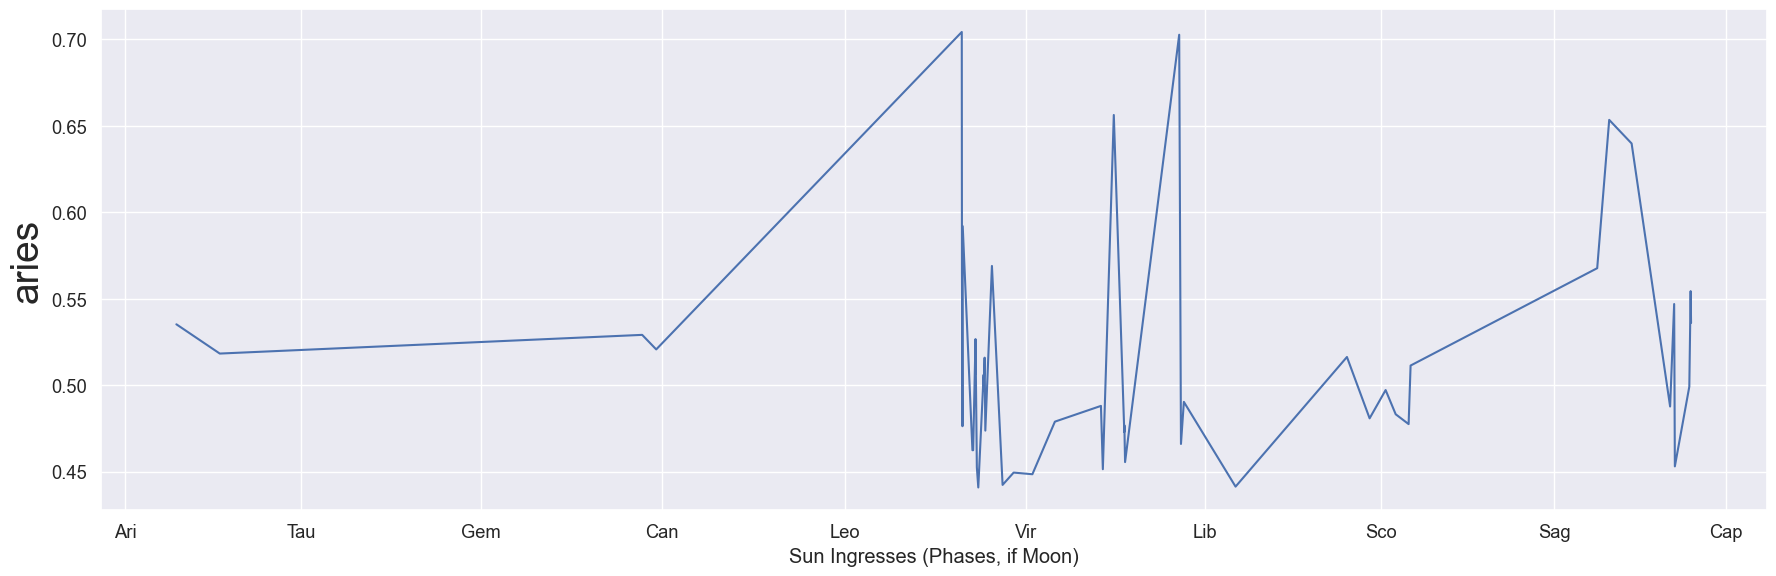

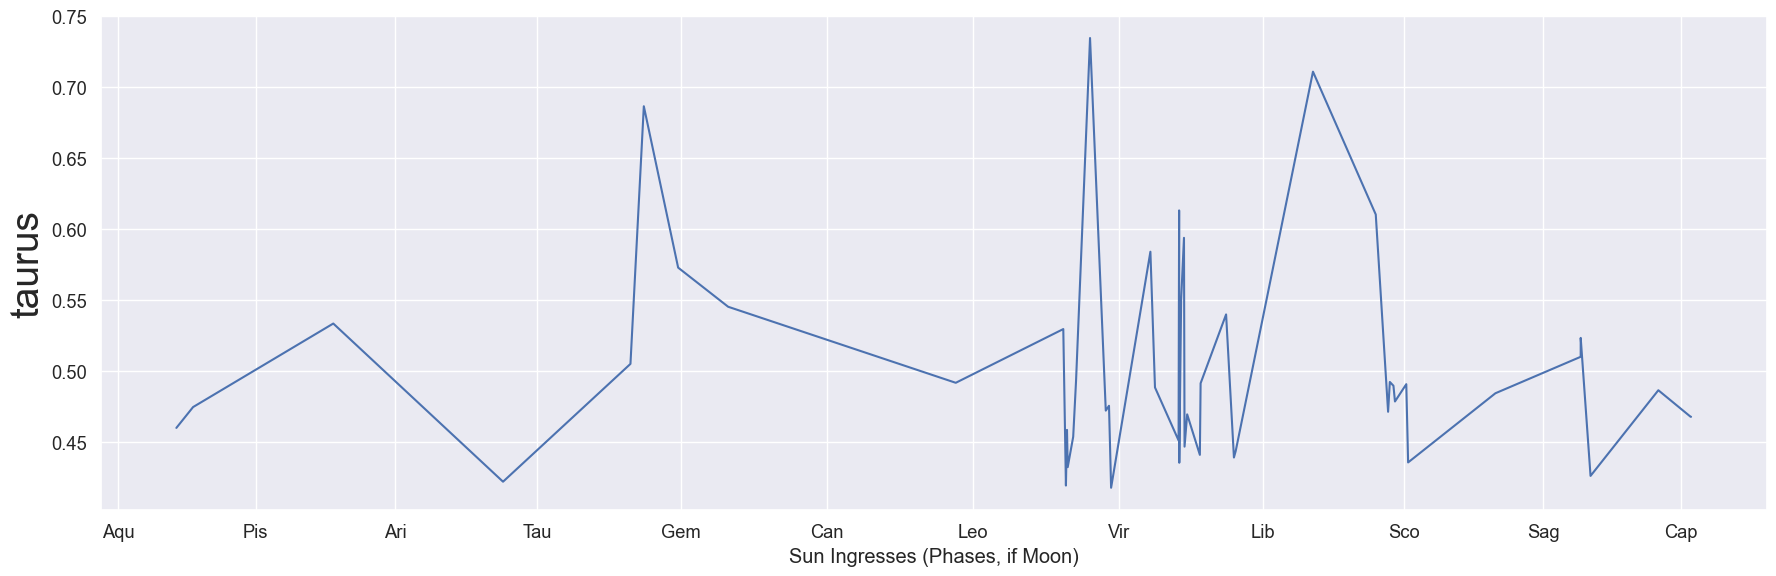

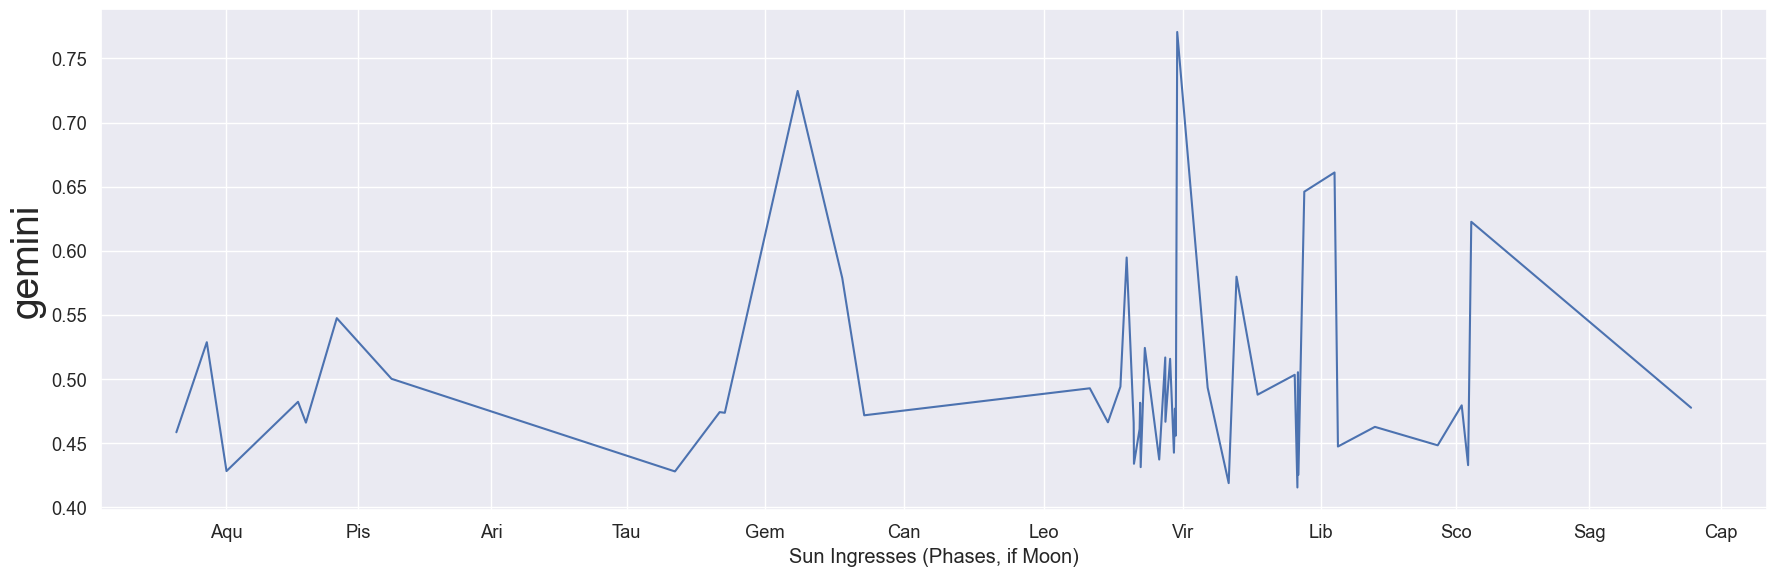

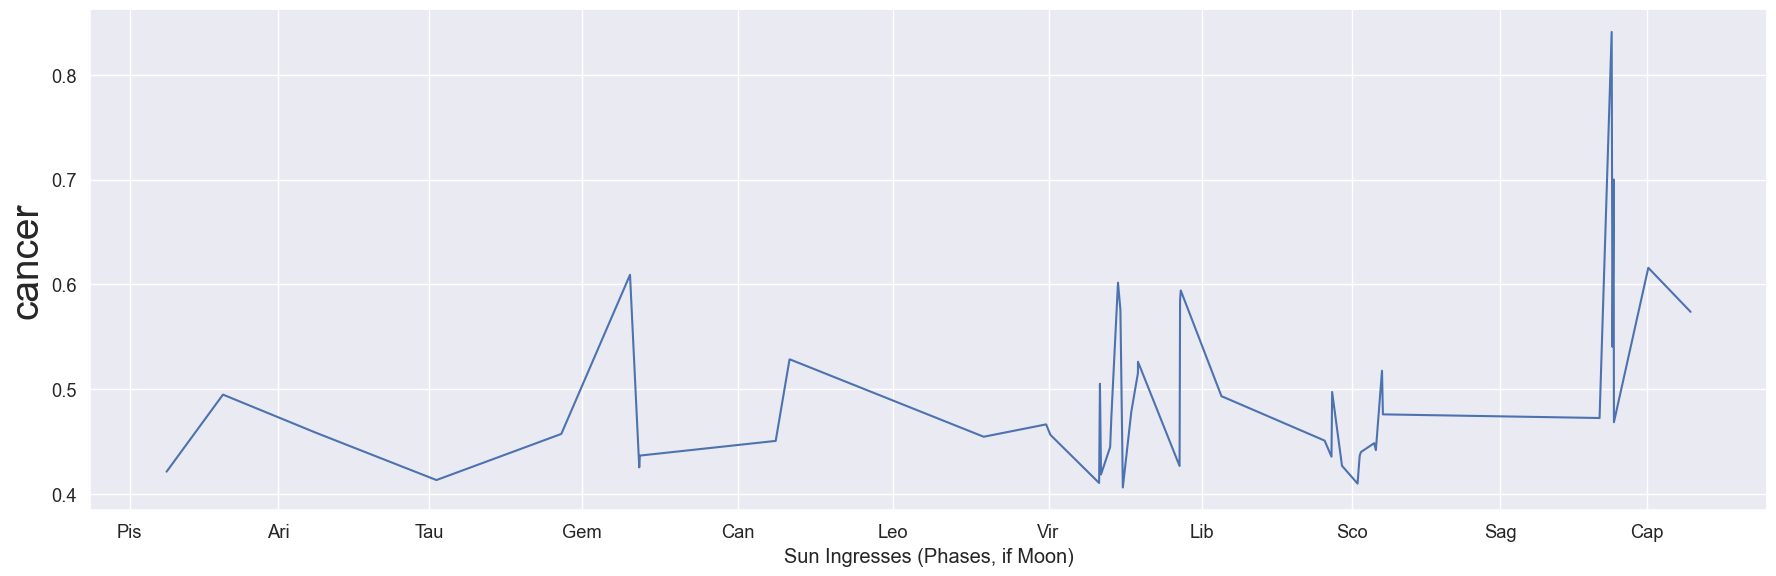

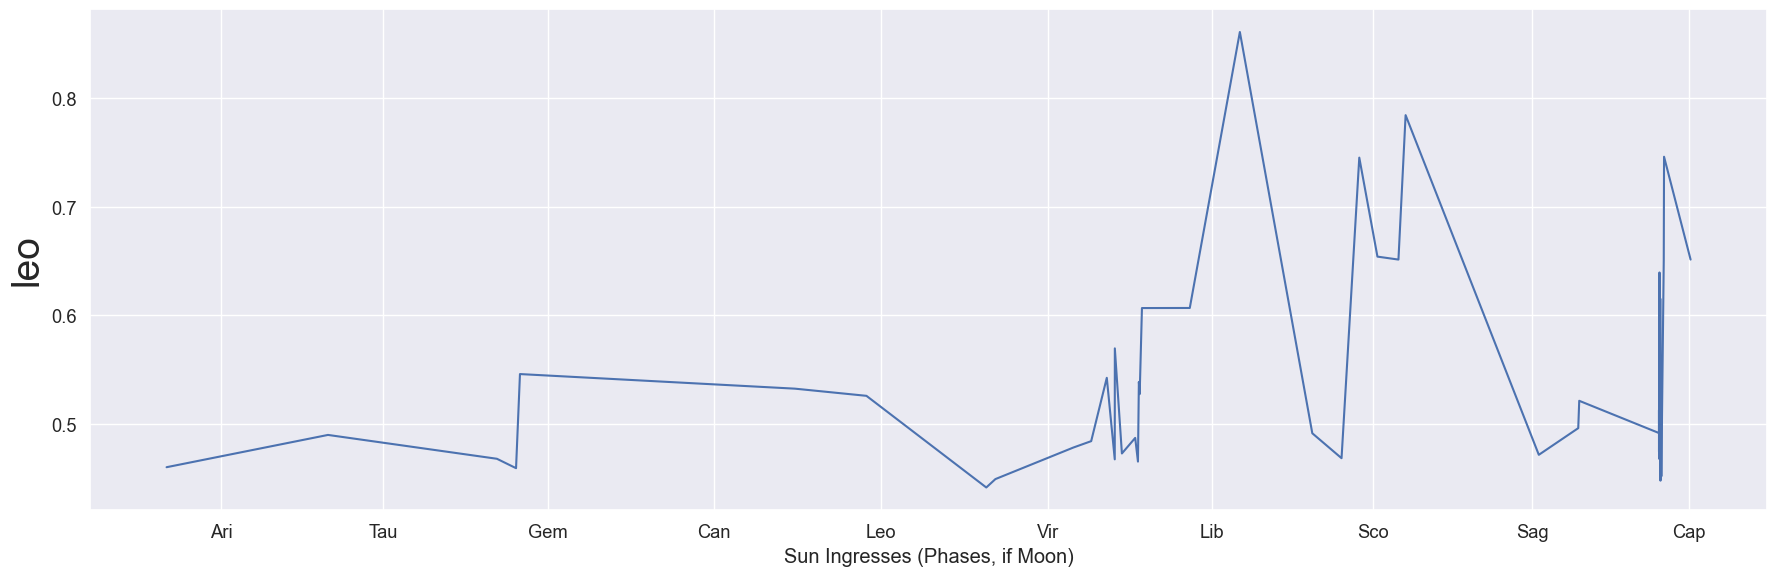

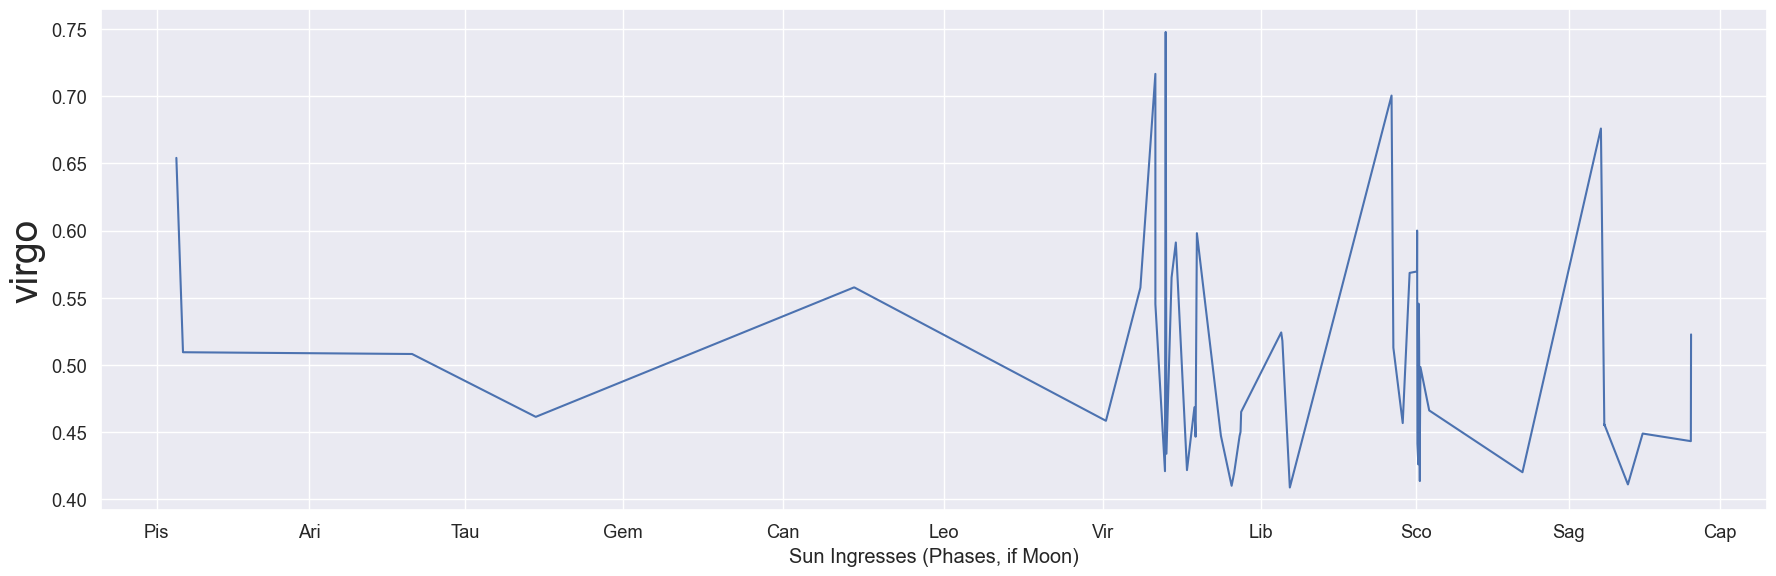

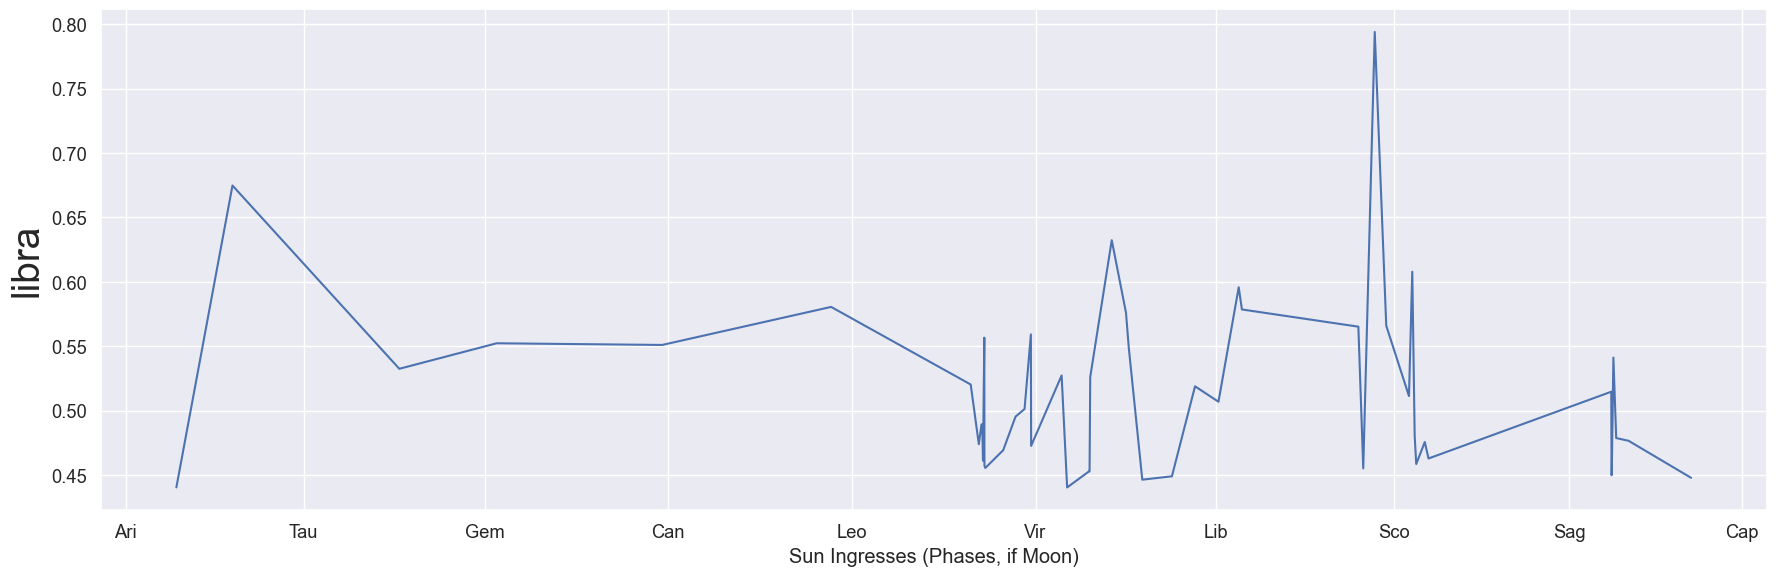

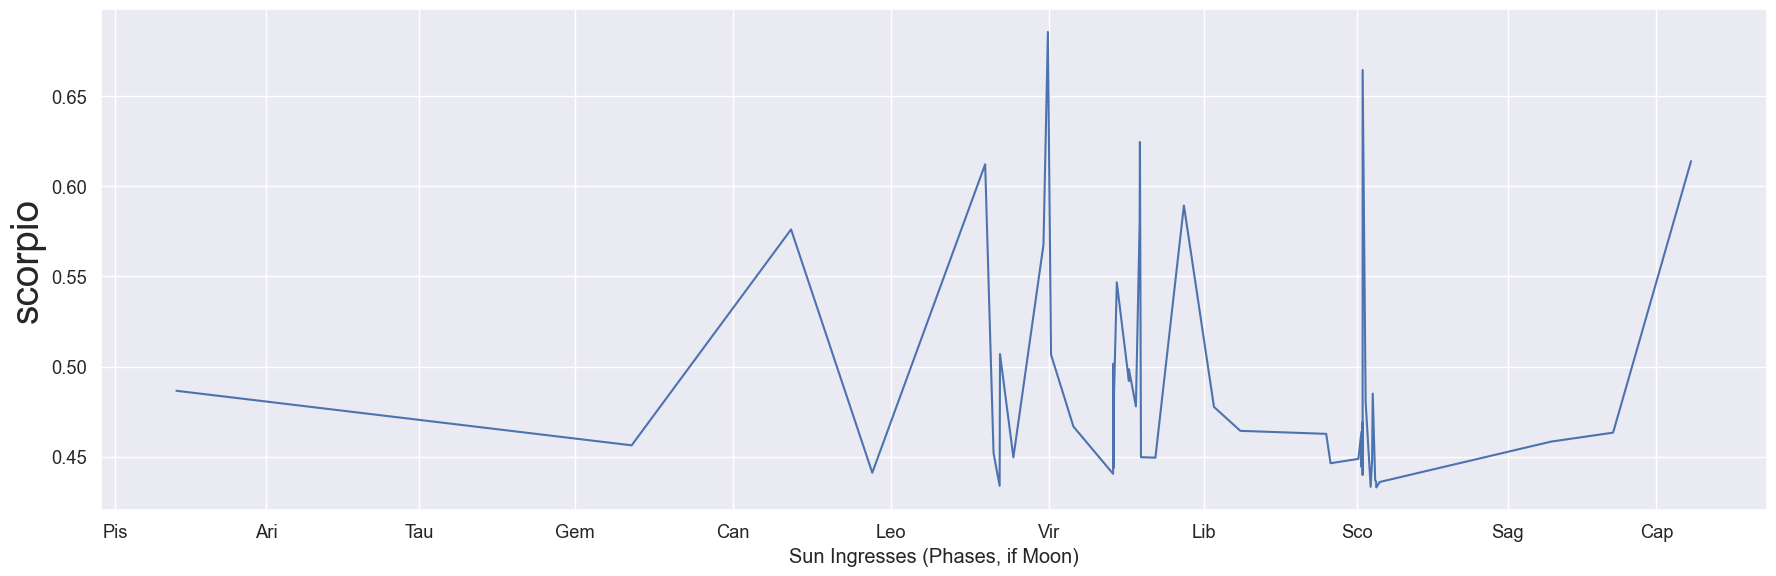

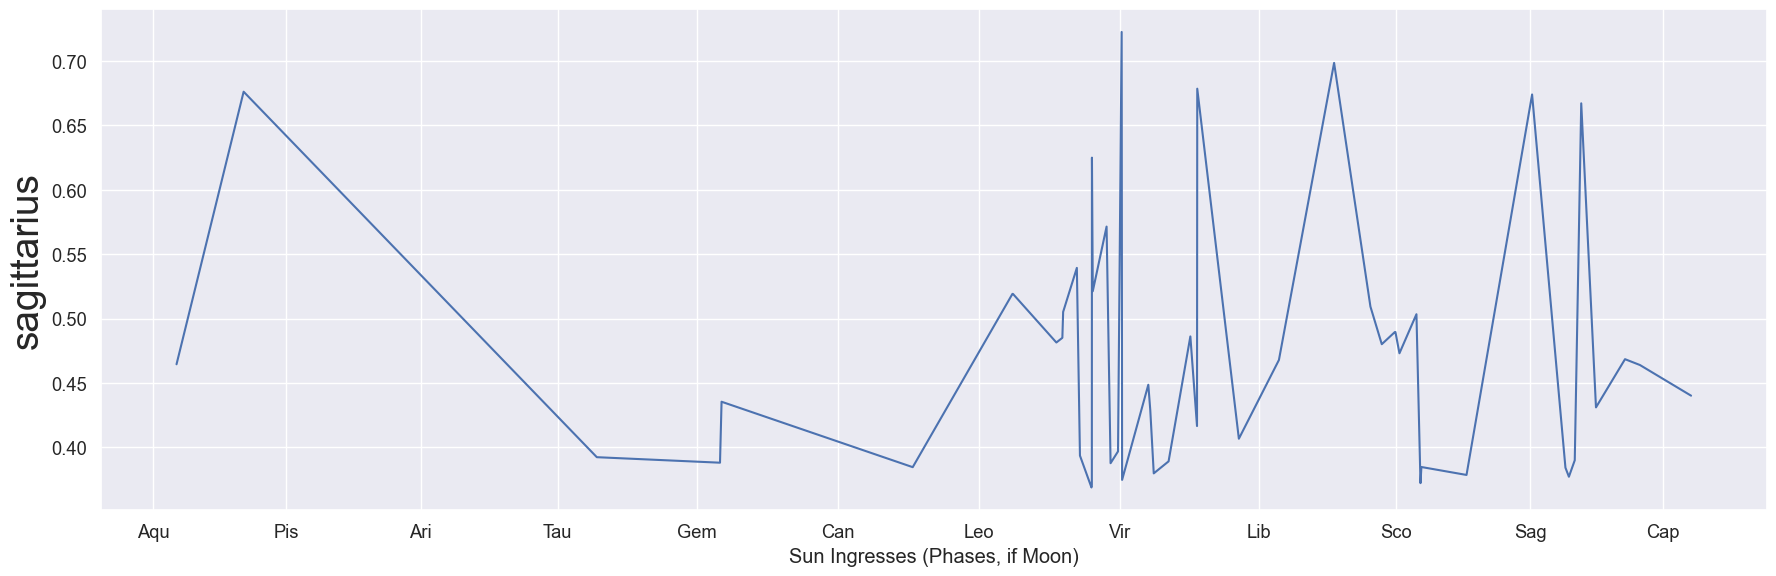

In [31]:
window = [
    'capricorn', 'aquarius', 'pisces', 'aries', 
    'taurus', 'gemini', 'cancer', 'leo', 
    'virgo', 'libra', 'scorpio', 'sagittarius']

df_tfidf2021 = df_tfidf[df_tfidf.year_==2021]
for sign in window:
    df_ = get_posts(df_tfidf2021, sign, 50, True)
    plot_key_over_time(df_, sign, 'Sun')

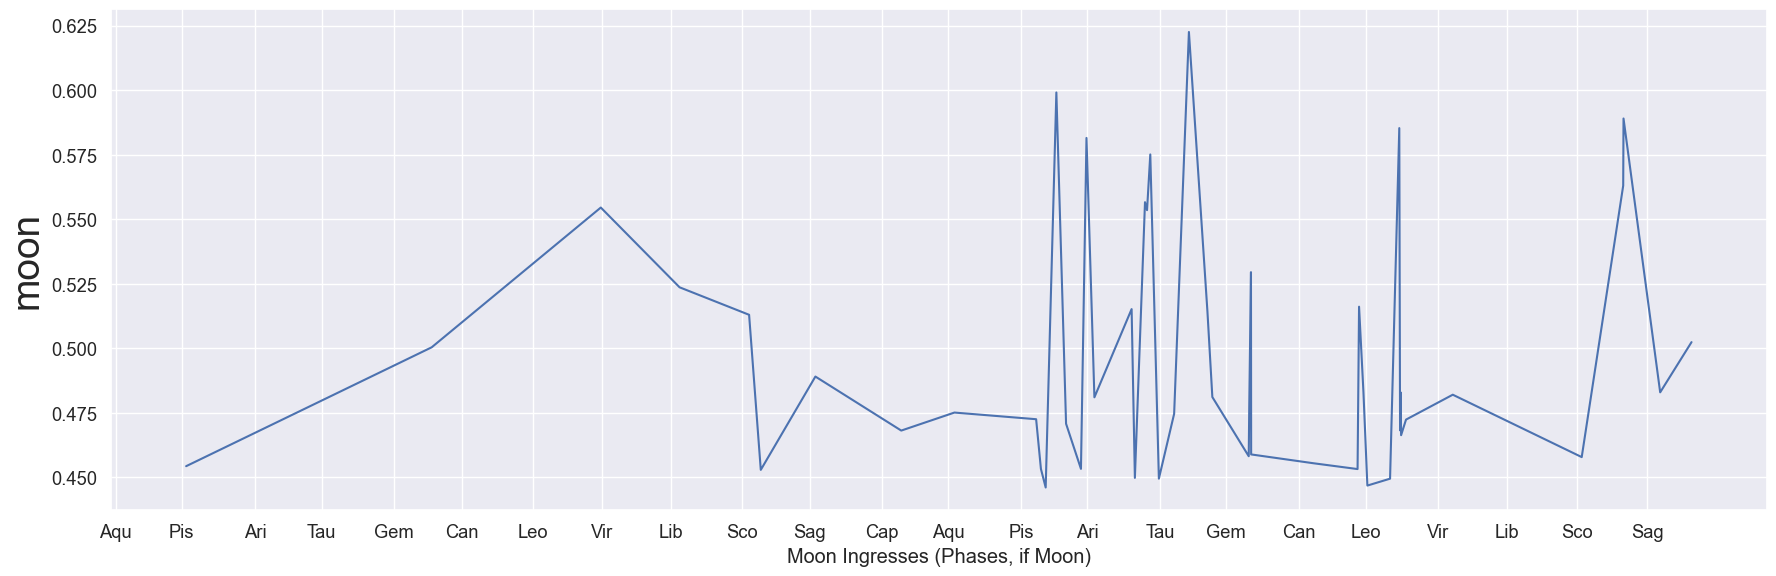

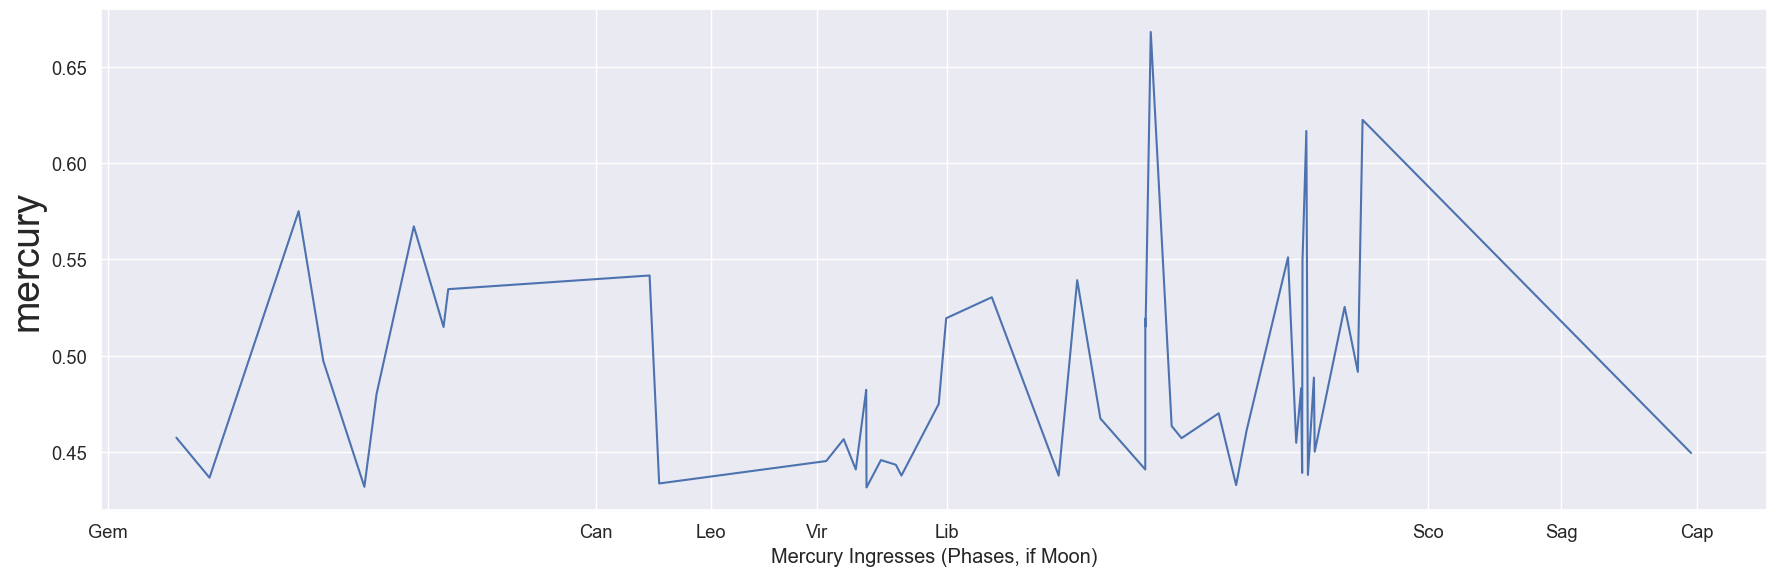

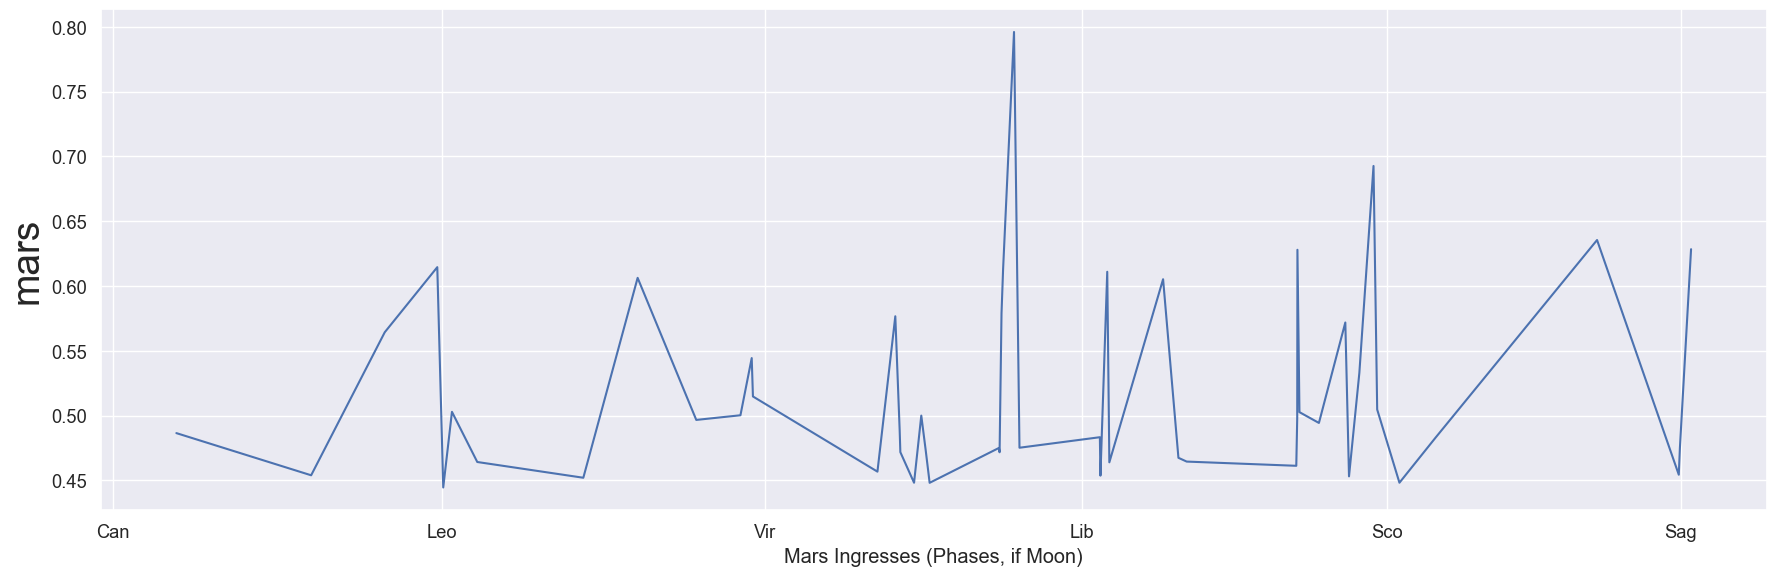

In [32]:
df_lun = get_posts(df_tfidf[df_tfidf.year_==2021], 'moon', 50, True)
df_mer = get_posts(df_tfidf[df_tfidf.year_==2021], 'mercury', 50, True)
df_mrs = get_posts(df_tfidf[df_tfidf.year_==2021], 'mars', 50, True)

plot_key_over_time(df_lun, 'moon', scale='Moon')
plot_key_over_time(df_mer, 'mercury', scale='Mercury')
plot_key_over_time(df_mrs, 'mars', scale='Mars')

In [33]:
def print_posts(df, key, num_posts):
    
    df_ = get_posts(df, key, num_posts)
    
    print('KEYWORD: '+ key + '_________________________________________________________')
    for i in df_.index:
        timestamp = df_.loc[i,'timestamp']
        text = df_.loc[i,'text_']
        print(f'{timestamp}, IDX {i}:')
        print(text)
        print()

In [34]:
print_posts(df_tfidf, 'mercury', 5)

KEYWORD: mercury_________________________________________________________
2025-03-21 11:11:21, IDX 19588:
Mercury Retrograde. **Heathrow shutdown leaves thousands stranded as power outage disrupts UK and international flights..**

It seems like the Mercury Retrograde is stronger than in previous years: https://www.bbc.co.uk/news/live/cly24zvvwxlt

2020-06-19 17:24:21, IDX 638:
Mercury Retrograde. http://decodingthesoul.blogspot.com/2020/06/mercury-retrograde-cancer-mercury-june.html

Hello, all! 

Just wanted to give you some info about the Mercury Retrograde that started late yesterday (June 17th). 

I hope it's helpful for you. Feel free to read and subscribe for more content if it resonates! 😊

2021-09-27 21:31:15, IDX 10559:
Eh, last Mercury retrograde I was up for a promotion and I didn’t go through with it. Not just because Mercury was in retrograde but other reasons too. And my gut feelings lead me to not accept it. Just have to do what is best for you

2025-04-27 13:12:18, IDX 

In [35]:
# Loading models for sentiment analysis & emotion detection
pretrained_stmt = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer_stmt = AutoTokenizer.from_pretrained(pretrained_stmt)
model_stmt = AutoModelForSequenceClassification.from_pretrained(pretrained_stmt)

pretrained_emot = 'bhadresh-savani/distilbert-base-uncased-emotion'
tokenizer_emot = AutoTokenizer.from_pretrained(pretrained_emot)
model_emot = AutoModelForSequenceClassification.from_pretrained(pretrained_emot)

sentiments = ['_negative', '_neutral', '_positive'] 
emotions   = model_emot.config.id2label

In [36]:
def probability_labels(text, sentiment=True):
    
    if sentiment:
        model     = model_stmt
        tokenizer = tokenizer_stmt
        labels    = sentiments
    else:
        model     = model_emot
        tokenizer = tokenizer_emot
        labels    = emotions
        
    tokens = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True,
        padding=True,
        max_length=512
    )
    
    with torch.no_grad():
        scores_ = model(**tokens)    
    scores = softmax(scores_.logits, dim=1)[0]
    
    probabilities = {labels[i]: float(scores[i]) for i in range(len(scores))}

    if sentiment:
        probabilities.update(probability_labels(text, sentiment=False))

    return probabilities

## Discussion & Conclusion